Connected to Python 3.9.6

In [ ]:
from tqdm.std import tqdm as _std_tqdm
import tqdm
tqdm.tqdm = _std_tqdm
globals()['tqdm'] = _std_tqdm

In [ ]:
import gym
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

/Users/cucuba/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Device: cpu


In [ ]:
class PreprocessFrame(gym.ObservationWrapper):
    def __init__(self, env, height=84, width=84, grayscale=True):
        super(PreprocessFrame, self).__init__(env)
        self.height = height
        self.width = width
        self.grayscale = grayscale
        self.observation_space = gym.spaces.Box(low=0, high=1.0,
                                                shape=(self.height, self.width),
                                                dtype=np.float32)
        
    def observation(self, obs):
        if self.grayscale:
            obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        obs = cv2.resize(obs, (self.width, self.height), interpolation=cv2.INTER_AREA)
        obs = obs.astype(np.float32) / 255.0
        return obs

In [ ]:
class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, sigma_init=0.017):
        super(NoisyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.weight_mu = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.register_buffer('weight_epsilon', torch.FloatTensor(out_features, in_features))
        
        self.bias_mu = nn.Parameter(torch.FloatTensor(out_features))
        self.bias_sigma = nn.Parameter(torch.FloatTensor(out_features))
        self.register_buffer('bias_epsilon', torch.FloatTensor(out_features))
        
        self.sigma_init = sigma_init
        self.reset_parameters()
        self.reset_noise()
        
    def reset_parameters(self):
        bound = 1 / math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-bound, bound)
        self.weight_sigma.data.fill_(self.sigma_init / math.sqrt(self.in_features))
        self.bias_mu.data.uniform_(-bound, bound)
        self.bias_sigma.data.fill_(self.sigma_init / math.sqrt(self.out_features))
        
    def reset_noise(self):
        epsilon_in = self._scale_noise(self.in_features)
        epsilon_out = self._scale_noise(self.out_features)
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)
        
    def _scale_noise(self, size):
        x = torch.randn(size)
        return x.sign().mul(x.abs().sqrt())
    
    def forward(self, input):
        if self.training:
            weight = self.weight_mu + self.weight_sigma * self.weight_epsilon
            bias = self.bias_mu + self.bias_sigma * self.bias_epsilon
        else:
            weight = self.weight_mu
            bias = self.bias_mu
        return F.linear(input, weight, bias)

In [ ]:
class RainbowDQN(nn.Module):
    def __init__(self, input_channels, num_actions, num_atoms=51, v_min=-10, v_max=10):
        super(RainbowDQN, self).__init__()
        self.num_actions = num_actions
        self.num_atoms = num_atoms
        self.v_min = v_min
        self.v_max = v_max
        self.register_buffer("support", torch.linspace(v_min, v_max, num_atoms))
        self.delta_z = (v_max - v_min) / (num_atoms - 1)
        
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        def conv2d_size_out(size, kernel_size, stride):
            return (size - kernel_size) // stride + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(84, 8, 4), 4, 2), 3, 1)
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(84, 8, 4), 4, 2), 3, 1)
        linear_input_size = convw * convh * 64
        
        self.fc_value = NoisyLinear(linear_input_size, 512)
        self.fc_advantage = NoisyLinear(linear_input_size, 512)
        self.value_stream = NoisyLinear(512, num_atoms)
        self.advantage_stream = NoisyLinear(512, num_actions * num_atoms)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        
        value = F.relu(self.fc_value(x))
        advantage = F.relu(self.fc_advantage(x))
        value = self.value_stream(value)  # shape: (batch, num_atoms)
        advantage = self.advantage_stream(advantage)  # shape: (batch, num_actions * num_atoms)
        advantage = advantage.view(-1, self.num_actions, self.num_atoms)
        
        q_atoms = value.unsqueeze(1) + advantage - advantage.mean(dim=1, keepdim=True)
        q_dist = F.softmax(q_atoms, dim=2)
        q_dist = q_dist.clamp(min=1e-3)  # for numerical stability
        return q_dist
    
    def reset_noise(self):
        for name, module in self.named_children():
            if isinstance(module, NoisyLinear):
                module.reset_noise()

In [ ]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.pos = 0
        
    def push(self, state, action, reward, next_state, done):
        max_priority = self.priorities.max() if self.buffer else 1.0
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)
        self.priorities[self.pos] = max_priority
        self.pos = (self.pos + 1) % self.capacity
        
    def sample(self, batch_size, beta):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:len(self.buffer)]
        probs = prios ** self.alpha
        probs /= probs.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights = np.array(weights, dtype=np.float32)
        batch = list(zip(*samples))
        states = np.array(batch[0])
        actions = np.array(batch[1])
        rewards = np.array(batch[2])
        next_states = np.array(batch[3])
        dones = np.array(batch[4])
        return states, actions, rewards, next_states, dones, indices, weights
        
    def update_priorities(self, batch_indices, batch_priorities):
        for idx, priority in zip(batch_indices, batch_priorities):
            self.priorities[idx] = priority

In [ ]:
class RainbowDQNAgent:
    def __init__(self, env, input_channels, num_actions,
                 num_atoms=51, v_min=-10, v_max=10,
                 learning_rate=1e-4, gamma=0.99,
                 buffer_size=100000, batch_size=32, multi_step=3,
                 update_target_every=1000, alpha=0.6,
                 beta_start=0.4, beta_frames=100000):
        
        self.env = env
        self.num_actions = num_actions
        self.batch_size = batch_size
        self.gamma = gamma
        self.multi_step = multi_step
        self.update_target_every = update_target_every
        self.beta_start = beta_start
        self.beta_frames = beta_frames
        self.frame_idx = 0
        self.beta = beta_start
        
        self.num_atoms = num_atoms
        self.v_min = v_min
        self.v_max = v_max
        self.delta_z = (v_max - v_min) / (num_atoms - 1)
        self.support = torch.linspace(v_min, v_max, num_atoms).to(device)
        
        self.online_net = RainbowDQN(input_channels, num_actions, num_atoms, v_min, v_max).to(device)
        self.target_net = RainbowDQN(input_channels, num_actions, num_atoms, v_min, v_max).to(device)
        self.target_net.load_state_dict(self.online_net.state_dict())
        
        self.optimizer = optim.Adam(self.online_net.parameters(), lr=learning_rate)
        self.replay_buffer = PrioritizedReplayBuffer(buffer_size, alpha)
    
    def select_action(self, state):
        state = np.array(state)
        if state.ndim == 3 and state.shape[-1] == 4:
            state = torch.FloatTensor(state).permute(2, 0, 1).unsqueeze(0).to(device)
        elif state.ndim == 3 and state.shape[0] == 4:
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
        else:
            raise ValueError("Unexpected state shape: {}".format(state.shape))
        with torch.no_grad():
            self.online_net.reset_noise()
            q_dist = self.online_net(state)  # (1, num_actions, num_atoms)
            q_values = torch.sum(q_dist * self.support, dim=2)
            action = q_values.argmax(1).item()
        return action
    
    def projection_distribution(self, next_state, reward, done):
        """
        Compute the projection of the target distribution onto the fixed support.
        """
        with torch.no_grad():
            self.target_net.reset_noise()
            next_state = torch.FloatTensor(next_state).to(device)
            if next_state.ndim == 3:
                next_state = next_state.unsqueeze(0)
            next_dist = self.target_net(next_state)  # shape: (1, num_actions, num_atoms)
            q_values = torch.sum(next_dist * self.support, dim=2)
            next_action = q_values.argmax(1).item()  # Convert to scalar
            next_dist = next_dist[0, next_action] 
        
        Tz = reward + (1 - done) * (self.gamma ** self.multi_step) * self.support.cpu().numpy()
        Tz = np.clip(Tz, self.v_min, self.v_max)
        b = (Tz - self.v_min) / self.delta_z
        l = np.floor(b).astype(np.int64)
        u = np.ceil(b).astype(np.int64)
        
        m = np.zeros(self.num_atoms, dtype=np.float32)
        for i in range(self.num_atoms):
            # Distribute probability mass to l and u
            if l[i] == u[i]:
                m[l[i]] += next_dist[i].item()
            else:
                m[l[i]] += next_dist[i].item() * (u[i] - b[i])
                m[u[i]] += next_dist[i].item() * (b[i] - l[i])
        return torch.FloatTensor(m).to(device)
    
    def update(self):
        if len(self.replay_buffer.buffer) < self.batch_size:
            return
        # Anneal beta towards 1
        self.beta = min(1.0, self.beta_start + self.frame_idx * (1.0 - self.beta_start) / self.beta_frames)
        states, actions, rewards, next_states, dones, indices, weights = self.replay_buffer.sample(self.batch_size, self.beta)
        
        states = torch.FloatTensor(states).to(device)
        if states.ndim == 4 and states.shape[-1] == 4:
            states = states.permute(0, 3, 1, 2)
        next_states = torch.FloatTensor(next_states).to(device)
        if next_states.ndim == 4 and next_states.shape[-1] == 4:
            next_states = next_states.permute(0, 3, 1, 2)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        dones = torch.FloatTensor(dones).to(device)
        weights = torch.FloatTensor(weights).to(device)
        
        self.online_net.reset_noise()
        dist = self.online_net(states)  # shape: (batch, num_actions, num_atoms)
        actions = actions.unsqueeze(1).unsqueeze(1).expand(self.batch_size, 1, self.num_atoms)
        dist = dist.gather(1, actions).squeeze(1)  # shape: (batch, num_atoms)
        dist = dist.clamp(min=1e-3)
        
        target_dist = []
        for i in range(self.batch_size):
            target_m = self.projection_distribution(next_states[i].cpu().numpy(),
                                          rewards[i].item(), dones[i].item())

            target_dist.append(target_m)
        target_dist = torch.stack(target_dist)  # shape: (batch, num_atoms)
        
        log_p = torch.log(dist)
        sample_losses = - (target_dist * log_p).sum(1)
        loss = (sample_losses * weights).mean()
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        new_priorities = sample_losses.detach().cpu().numpy() + 1e-6
        self.replay_buffer.update_priorities(indices, new_priorities)
        
        if self.frame_idx % self.update_target_every == 0:
            self.target_net.load_state_dict(self.online_net.state_dict())
    
    def train(self, num_frames):
        state = self.env.reset()
        episode_reward = 0
        all_rewards = []
        pbar = tqdm(total=num_frames, desc="Training", initial=self.frame_idx)
        while self.frame_idx < num_frames:
            action = self.select_action(state)
            next_state, reward, done, _ = self.env.step(action)
            self.replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward

            self.update()
            self.frame_idx += 1
            pbar.update(1)

            if done:
                state = self.env.reset()
                all_rewards.append(episode_reward)
                pbar.set_postfix({'Episode Reward': episode_reward})
                print(f"Frame: {self.frame_idx}, Episode Reward: {episode_reward}")
                episode_reward = 0
        pbar.close()
        print("▶Training finished!")  # new add
        return all_rewards

In [ ]:
def run_experiment(hparams):
    env = gym.make('MsPacman-v0')
    env = PreprocessFrame(env)
    env = gym.wrappers.FrameStack(env, num_stack=4)
    
    num_actions = env.action_space.n
    input_channels = 4 
    
    agent = RainbowDQNAgent(
        env,
        input_channels,
        num_actions,
        num_atoms=hparams.get('num_atoms', 51),
        v_min=hparams.get('v_min', -10),
        v_max=hparams.get('v_max', 10),
        learning_rate=hparams['learning_rate'],
        gamma=hparams['gamma'],
        buffer_size=hparams['buffer_size'],
        batch_size=hparams['batch_size'],
        multi_step=hparams['multi_step'],
        update_target_every=hparams['update_target_every'],
        alpha=hparams['alpha'],
        beta_start=hparams['beta_start'],
        beta_frames=hparams['beta_frames']
    )

    # Train the agent and collect rewards
    rewards = agent.train(hparams['total_frames'])
    return rewards
    

    
    """current_dir = os.path.dirname(os.path.abspath(__file__))
    
    # load saved model
    name = '0'
    weights_path = os.path.join(current_dir, "weights",  f"rainbow_dqn_weights_{name}.pth")
    if os.path.exists(weights_path):
        print("Loading saved model weights...")
        agent.online_net.load_state_dict(torch.load(weights_path))
        agent.target_net.load_state_dict(agent.online_net.state_dict())
    else:
        print("No saved model weights found. Starting training from scratch.")
    if os.path.exists(os.path.join(current_dir, "weights", f"rainbow_dqn_state_{name}.pkl")):
        print("Loading training state...")
        with open(os.path.join(current_dir, "weights", f"rainbow_dqn_state_{name}.pkl"), "rb") as f:
            state = pickle.load(f)
            agent.frame_idx = state["frame_idx"]
            agent.replay_buffer = state["replay_buffer"]
        print(f"Resuming training from frame {agent.frame_idx}.")
    else:
        print("No saved training state found. Starting training from scratch.")
    
    os.makedirs(os.path.join(current_dir, "weights"), exist_ok=True)
    rewards = agent.train(total_frames)
    
    # save model
    with open(os.path.join(current_dir, "weights", f"rainbow_dqn_state_{total_frames}.pkl"), "wb") as f:
        pickle.dump({
            "frame_idx": agent.frame_idx,
            "replay_buffer": agent.replay_buffer
        }, f)
    torch.save(agent.online_net.state_dict(), os.path.join(current_dir, "weights", f"rainbow_dqn_weights_{total_frames}.pth"))"""

# Storage for all experiment results
all_results = {}
all_results_large = {}

"""
lrs       = [1e-5, 5e-5]
multi_ss  = [3,    5]
alphas    = [0.4,  0.6]

"""

'\nlrs       = [1e-5, 5e-5]\nmulti_ss  = [3,    5]\nalphas    = [0.4,  0.6]\n\n'

In [ ]:
hparams_A = {
    'learning_rate': 1e-5,
    'gamma': 0.99,
    'buffer_size': 100000,
    'batch_size': 32,
    'multi_step': 3,
    'update_target_every': 1000,
    'alpha': 0.4,
    'beta_start': 0.4,
    'beta_frames': 100000,
    'total_frames': 30000
}

In [ ]:
#Choose Better performance to test large 
# 'buffer_size': 100000 -> 1000000
#'update_target_every': 1000 -> 5000
#'beta_frames': 100000 ->500000
# Experiment F: lr=5e-5, multi_step=3, alpha=0.6 
hparams_E_large = hparams_A.copy()
hparams_E_large['learning_rate'] = 5e-5
hparams_E_large['buffer_size'] = 1000000
hparams_E_large['update_target_every'] = 5000
hparams_E_large['beta_frames'] = 500000

rewards_E_large = run_experiment(hparams_E_large)
all_results_large['E'] = (hparams_E_large, rewards_E_large)

/Users/cucuba/Library/Python/3.9/lib/python/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment MsPacman-v0 is out of date. You should consider upgrading to version `v5` with the environment ID `ALE/MsPacman-v5`.
  logger.warn(
A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]
Training:   2%|▏         | 662/30000 [01:28<1:16:06,  6.42it/s, Episode Reward=60]

Frame: 661, Episode Reward: 60.0


Training:   4%|▍         | 1306/30000 [03:09<1:17:16,  6.19it/s, Episode Reward=60]

Frame: 1305, Episode Reward: 60.0


Training:   7%|▋         | 1954/30000 [04:59<1:17:06,  6.06it/s, Episode Reward=60]

Frame: 1953, Episode Reward: 60.0


Training:   9%|▉         | 2638/30000 [06:57<1:26:11,  5.29it/s, Episode Reward=70]

Frame: 2637, Episode Reward: 70.0


Training:  11%|█         | 3220/30000 [08:40<1:20:24,  5.55it/s, Episode Reward=90]

Frame: 3219, Episode Reward: 90.0


Training:  13%|█▎        | 3809/30000 [10:27<1:21:57,  5.33it/s, Episode Reward=110]

Frame: 3808, Episode Reward: 110.0


Training:  15%|█▍        | 4454/30000 [12:22<1:14:28,  5.72it/s, Episode Reward=60] 

Frame: 4453, Episode Reward: 60.0


Training:  17%|█▋        | 5119/30000 [14:22<1:11:47,  5.78it/s, Episode Reward=60]

Frame: 5118, Episode Reward: 60.0


Training:  20%|██        | 6076/30000 [17:16<1:14:44,  5.33it/s, Episode Reward=810]

Frame: 6075, Episode Reward: 810.0


Training:  23%|██▎       | 6771/30000 [19:21<1:12:05,  5.37it/s, Episode Reward=110]

Frame: 6770, Episode Reward: 110.0


Training:  25%|██▍       | 7477/30000 [21:34<1:06:23,  5.65it/s, Episode Reward=170]

Frame: 7476, Episode Reward: 170.0


Training:  27%|██▋       | 8162/30000 [23:42<1:06:41,  5.46it/s, Episode Reward=410]

Frame: 8161, Episode Reward: 410.0


Training:  29%|██▉       | 8705/30000 [25:24<1:08:24,  5.19it/s, Episode Reward=140]

Frame: 8704, Episode Reward: 140.0


Training:  32%|███▏      | 9472/30000 [27:47<1:04:46,  5.28it/s, Episode Reward=240]

Frame: 9471, Episode Reward: 240.0


Training:  34%|███▍      | 10148/30000 [29:52<1:01:31,  5.38it/s, Episode Reward=120]

Frame: 10147, Episode Reward: 120.0


Training:  36%|███▌      | 10868/30000 [32:07<1:00:15,  5.29it/s, Episode Reward=170]

Frame: 10867, Episode Reward: 170.0


Training:  38%|███▊      | 11544/30000 [34:12<56:21,  5.46it/s, Episode Reward=180]  

Frame: 11543, Episode Reward: 180.0


Training:  40%|████      | 12141/30000 [36:05<54:44,  5.44it/s, Episode Reward=120]  

Frame: 12140, Episode Reward: 120.0


Training:  43%|████▎     | 12812/30000 [38:06<1:07:03,  4.27it/s, Episode Reward=230]

Frame: 12812, Episode Reward: 230.0


Training:  45%|████▍     | 13467/30000 [40:09<49:42,  5.54it/s, Episode Reward=230]  

Frame: 13466, Episode Reward: 230.0


Training:  48%|████▊     | 14384/30000 [42:55<47:34,  5.47it/s, Episode Reward=380]

Frame: 14383, Episode Reward: 380.0


Training:  50%|█████     | 15032/30000 [44:56<47:06,  5.30it/s, Episode Reward=200]

Frame: 15031, Episode Reward: 200.0


Training:  52%|█████▏    | 15646/30000 [46:50<43:40,  5.48it/s, Episode Reward=360]  

Frame: 15645, Episode Reward: 360.0


Training:  54%|█████▍    | 16200/30000 [48:31<41:25,  5.55it/s, Episode Reward=200]

Frame: 16199, Episode Reward: 200.0


Training:  57%|█████▋    | 17118/30000 [51:18<38:09,  5.63it/s, Episode Reward=640]

Frame: 17117, Episode Reward: 640.0


Training:  59%|█████▉    | 17833/30000 [53:27<37:22,  5.43it/s, Episode Reward=290]

Frame: 17832, Episode Reward: 290.0


Training:  61%|██████▏   | 18433/30000 [55:15<35:48,  5.38it/s, Episode Reward=370]

Frame: 18432, Episode Reward: 370.0


Training:  63%|██████▎   | 19027/30000 [57:02<33:47,  5.41it/s, Episode Reward=370]

Frame: 19026, Episode Reward: 370.0


Training:  66%|██████▌   | 19651/30000 [58:55<30:33,  5.65it/s, Episode Reward=370]

Frame: 19650, Episode Reward: 370.0


Training:  68%|██████▊   | 20414/30000 [1:01:18<30:58,  5.16it/s, Episode Reward=370]

Frame: 20413, Episode Reward: 370.0


Training:  71%|███████   | 21225/30000 [1:03:46<28:04,  5.21it/s, Episode Reward=620]

Frame: 21224, Episode Reward: 620.0


Training:  73%|███████▎  | 21829/30000 [1:05:37<24:53,  5.47it/s, Episode Reward=320]

Frame: 21828, Episode Reward: 320.0


Training:  75%|███████▍  | 22474/30000 [1:07:33<22:47,  5.50it/s, Episode Reward=370]

Frame: 22473, Episode Reward: 370.0


Training:  77%|███████▋  | 23242/30000 [1:09:54<20:31,  5.49it/s, Episode Reward=420]

Frame: 23241, Episode Reward: 420.0


Training:  81%|████████  | 24172/30000 [1:12:51<18:08,  5.36it/s, Episode Reward=450]

Frame: 24171, Episode Reward: 450.0


Training:  83%|████████▎ | 24906/30000 [1:15:14<15:45,  5.39it/s, Episode Reward=300]

Frame: 24906, Episode Reward: 300.0


Training:  85%|████████▌ | 25535/30000 [1:17:13<14:23,  5.17it/s, Episode Reward=290]

Frame: 25534, Episode Reward: 290.0


Training:  88%|████████▊ | 26259/30000 [1:19:28<11:09,  5.59it/s, Episode Reward=340]

Frame: 26258, Episode Reward: 340.0


Training:  90%|████████▉ | 26936/30000 [1:21:37<09:55,  5.15it/s, Episode Reward=390]

Frame: 26935, Episode Reward: 390.0


Training:  92%|█████████▏| 27664/30000 [1:23:54<08:46,  4.44it/s, Episode Reward=390]

Frame: 27664, Episode Reward: 390.0


Training:  95%|█████████▌| 28519/30000 [1:26:35<04:39,  5.31it/s, Episode Reward=660]

Frame: 28518, Episode Reward: 660.0


Training:  98%|█████████▊| 29291/30000 [1:29:01<02:14,  5.29it/s, Episode Reward=670]

Frame: 29290, Episode Reward: 670.0


Training: 100%|██████████| 30000/30000 [1:31:13<00:00,  5.48it/s, Episode Reward=670]


▶Training finished!


In [ ]:
#Choose Better performance to test large 
# 'buffer_size': 100000 -> 1000000
#'update_target_every': 1000 -> 5000
#'beta_frames': 100000 ->500000
# Experiment F: lr=5e-5, multi_step=3, alpha=0.6 
hparams_F_large = hparams_A.copy()
hparams_F_large['learning_rate'] = 5e-5
hparams_F_large['alpha'] = 0.6
hparams_F_large['buffer_size'] = 1000000
hparams_F_large['update_target_every'] = 5000
hparams_F_large['beta_frames'] = 500000

rewards_F_large = run_experiment(hparams_F_large)
all_results_large['F'] = (hparams_F_large, rewards_F_large)

/Users/cucuba/Library/Python/3.9/lib/python/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment MsPacman-v0 is out of date. You should consider upgrading to version `v5` with the environment ID `ALE/MsPacman-v5`.
  logger.warn(
Training:   2%|▏         | 650/30000 [01:36<1:25:08,  5.75it/s, Episode Reward=60]

Frame: 649, Episode Reward: 60.0


Training:   4%|▍         | 1295/30000 [03:27<1:26:34,  5.53it/s, Episode Reward=160]

Frame: 1294, Episode Reward: 160.0


Training:   7%|▋         | 2052/30000 [05:51<1:32:06,  5.06it/s, Episode Reward=310]

Frame: 2051, Episode Reward: 310.0


Training:  10%|▉         | 2982/30000 [08:50<1:24:37,  5.32it/s, Episode Reward=230]

Frame: 2981, Episode Reward: 230.0


Training:  13%|█▎        | 3964/30000 [11:59<1:24:32,  5.13it/s, Episode Reward=430]

Frame: 3963, Episode Reward: 430.0


Training:  16%|█▌        | 4728/30000 [14:28<1:20:39,  5.22it/s, Episode Reward=250]

Frame: 4727, Episode Reward: 250.0


Training:  18%|█▊        | 5473/30000 [16:57<1:21:54,  4.99it/s, Episode Reward=160]

Frame: 5472, Episode Reward: 160.0


Training:  21%|██        | 6186/30000 [19:15<1:17:07,  5.15it/s, Episode Reward=220]

Frame: 6185, Episode Reward: 220.0


Training:  24%|██▍       | 7216/30000 [22:41<1:20:43,  4.70it/s, Episode Reward=500]

Frame: 7216, Episode Reward: 500.0


Training:  27%|██▋       | 8172/30000 [25:52<1:13:27,  4.95it/s, Episode Reward=300]

Frame: 8172, Episode Reward: 300.0


Training:  30%|██▉       | 8998/30000 [28:39<1:09:19,  5.05it/s, Episode Reward=320]

Frame: 8997, Episode Reward: 320.0


Training:  32%|███▏      | 9662/30000 [30:53<1:06:28,  5.10it/s, Episode Reward=270]

Frame: 9662, Episode Reward: 270.0


Training:  36%|███▌      | 10655/30000 [34:17<1:03:26,  5.08it/s, Episode Reward=250]

Frame: 10655, Episode Reward: 250.0


Training:  39%|███▉      | 11762/30000 [38:00<59:11,  5.14it/s, Episode Reward=520]  

Frame: 11761, Episode Reward: 520.0


Training:  42%|████▏     | 12535/30000 [40:36<59:02,  4.93it/s, Episode Reward=230]  

Frame: 12535, Episode Reward: 230.0


Training:  44%|████▍     | 13289/30000 [43:08<56:25,  4.94it/s, Episode Reward=320]  

Frame: 13288, Episode Reward: 320.0


Training:  47%|████▋     | 14014/30000 [45:33<53:27,  4.98it/s, Episode Reward=170]  

Frame: 14014, Episode Reward: 170.0


Training:  49%|████▉     | 14746/30000 [48:05<51:09,  4.97it/s, Episode Reward=230]  

Frame: 14746, Episode Reward: 230.0


Training:  52%|█████▏    | 15473/30000 [50:30<48:02,  5.04it/s, Episode Reward=230]

Frame: 15472, Episode Reward: 230.0


Training:  55%|█████▍    | 16451/30000 [53:47<44:05,  5.12it/s, Episode Reward=240]

Frame: 16450, Episode Reward: 240.0


Training:  57%|█████▋    | 17080/30000 [55:51<44:50,  4.80it/s, Episode Reward=150]

Frame: 17080, Episode Reward: 150.0


Training:  59%|█████▉    | 17757/30000 [58:04<41:23,  4.93it/s, Episode Reward=330]

Frame: 17756, Episode Reward: 330.0


Training:  61%|██████▏   | 18403/30000 [1:00:10<38:28,  5.02it/s, Episode Reward=300]

Frame: 18402, Episode Reward: 300.0


Training:  64%|██████▍   | 19318/30000 [1:03:11<35:43,  4.98it/s, Episode Reward=250]

Frame: 19317, Episode Reward: 250.0


Training:  67%|██████▋   | 20050/30000 [1:05:35<32:48,  5.05it/s, Episode Reward=250]

Frame: 20050, Episode Reward: 250.0


Training:  71%|███████   | 21156/30000 [1:09:15<29:06,  5.06it/s, Episode Reward=350]

Frame: 21156, Episode Reward: 350.0


Training:  73%|███████▎  | 21962/30000 [1:11:54<26:29,  5.06it/s, Episode Reward=240]

Frame: 21961, Episode Reward: 240.0


Training:  76%|███████▋  | 22881/30000 [1:14:55<22:42,  5.23it/s, Episode Reward=380]

Frame: 22881, Episode Reward: 380.0


Training:  78%|███████▊  | 23525/30000 [1:17:02<20:50,  5.18it/s, Episode Reward=310]

Frame: 23524, Episode Reward: 310.0


Training:  81%|████████  | 24178/30000 [1:19:10<19:01,  5.10it/s, Episode Reward=240]

Frame: 24177, Episode Reward: 240.0


Training:  83%|████████▎ | 24803/30000 [1:21:17<16:51,  5.14it/s, Episode Reward=320]

Frame: 24803, Episode Reward: 320.0


Training:  85%|████████▍ | 25429/30000 [1:23:20<15:00,  5.08it/s, Episode Reward=270]

Frame: 25428, Episode Reward: 270.0


Training:  87%|████████▋ | 26017/30000 [1:25:15<13:17,  5.00it/s, Episode Reward=240]

Frame: 26017, Episode Reward: 240.0


Training:  89%|████████▉ | 26744/30000 [1:27:43<10:09,  5.35it/s, Episode Reward=290]

Frame: 26743, Episode Reward: 290.0


Training:  92%|█████████▏| 27509/30000 [1:30:13<08:07,  5.11it/s, Episode Reward=300]

Frame: 27509, Episode Reward: 300.0


Training:  94%|█████████▍| 28137/30000 [1:32:18<05:52,  5.28it/s, Episode Reward=300]

Frame: 28136, Episode Reward: 300.0


Training:  96%|█████████▋| 28913/30000 [1:34:50<03:35,  5.04it/s, Episode Reward=300]

Frame: 28913, Episode Reward: 300.0


Training:  99%|█████████▉| 29657/30000 [1:37:16<01:06,  5.14it/s, Episode Reward=310]

Frame: 29657, Episode Reward: 310.0


Training: 100%|██████████| 30000/30000 [1:38:24<00:00,  5.08it/s, Episode Reward=310]


▶Training finished!


In [ ]:
#Choose Better performance to test large 
# 'buffer_size': 100000 -> 1000000
#'update_target_every': 1000 -> 5000
#'beta_frames': 100000 ->500000
# Experiment F: lr=5e-5, multi_step=3, alpha=0.6 
hparams_G_large = hparams_A.copy()
hparams_G_large['learning_rate'] = 5e-5
hparams_G_large['multi_step'] = 5
hparams_G_large['buffer_size'] = 1000000
hparams_G_large['update_target_every'] = 5000
hparams_G_large['beta_frames'] = 500000

rewards_G_large = run_experiment(hparams_G_large)
all_results_large['F'] = (hparams_G_large, rewards_G_large)

Training:   2%|▏         | 706/30000 [01:33<1:19:00,  6.18it/s, Episode Reward=70]

Frame: 705, Episode Reward: 70.0


Training:   5%|▍         | 1403/30000 [03:24<1:14:32,  6.39it/s, Episode Reward=70]

Frame: 1402, Episode Reward: 70.0


Training:   7%|▋         | 2106/30000 [05:23<1:17:39,  5.99it/s, Episode Reward=110]

Frame: 2105, Episode Reward: 110.0


Training:   9%|▉         | 2812/30000 [07:33<1:23:33,  5.42it/s, Episode Reward=70] 

Frame: 2811, Episode Reward: 70.0


Training:  12%|█▏        | 3507/30000 [09:44<1:23:17,  5.30it/s, Episode Reward=70]

Frame: 3506, Episode Reward: 70.0


Training:  14%|█▍        | 4216/30000 [11:57<1:19:56,  5.38it/s, Episode Reward=70]

Frame: 4215, Episode Reward: 70.0


Training:  16%|█▋        | 4922/30000 [14:14<1:22:47,  5.05it/s, Episode Reward=70]

Frame: 4922, Episode Reward: 70.0


Training:  19%|█▊        | 5624/30000 [16:30<1:18:04,  5.20it/s, Episode Reward=70]

Frame: 5623, Episode Reward: 70.0


Training:  21%|██        | 6330/30000 [18:45<1:15:59,  5.19it/s, Episode Reward=70]

Frame: 6329, Episode Reward: 70.0


Training:  23%|██▎       | 7036/30000 [21:03<1:08:33,  5.58it/s, Episode Reward=70]

Frame: 7036, Episode Reward: 70.0


Training:  26%|██▌       | 7745/30000 [23:21<1:13:34,  5.04it/s, Episode Reward=80]

Frame: 7744, Episode Reward: 80.0


Training:  28%|██▊       | 8449/30000 [25:39<1:10:23,  5.10it/s, Episode Reward=80]

Frame: 8448, Episode Reward: 80.0


Training:  31%|███       | 9158/30000 [27:59<1:11:03,  4.89it/s, Episode Reward=80]

Frame: 9157, Episode Reward: 80.0


Training:  33%|███▎      | 9873/30000 [30:22<1:08:03,  4.93it/s, Episode Reward=80]

Frame: 9873, Episode Reward: 80.0


Training:  35%|███▌      | 10586/30000 [32:46<1:05:07,  4.97it/s, Episode Reward=80]

Frame: 10585, Episode Reward: 80.0


Training:  38%|███▊      | 11296/30000 [35:10<1:06:25,  4.69it/s, Episode Reward=80]

Frame: 11295, Episode Reward: 80.0


Training:  40%|███▉      | 11999/30000 [37:34<1:00:16,  4.98it/s, Episode Reward=80]

Frame: 11999, Episode Reward: 80.0


Training:  42%|████▏     | 12708/30000 [39:58<1:01:56,  4.65it/s, Episode Reward=80]

Frame: 12707, Episode Reward: 80.0


Training:  45%|████▍     | 13413/30000 [42:31<57:06,  4.84it/s, Episode Reward=80]  

Frame: 13412, Episode Reward: 80.0


Training:  47%|████▋     | 14092/30000 [44:55<55:11,  4.80it/s, Episode Reward=170] 

Frame: 14092, Episode Reward: 170.0


Training:  49%|████▉     | 14835/30000 [47:33<54:23,  4.65it/s, Episode Reward=80]   

Frame: 14835, Episode Reward: 80.0


Training:  52%|█████▏    | 15629/30000 [50:23<49:30,  4.84it/s, Episode Reward=320] 

Frame: 15629, Episode Reward: 320.0


Training:  54%|█████▍    | 16181/30000 [52:19<49:35,  4.64it/s, Episode Reward=340]

Frame: 16181, Episode Reward: 340.0


Training:  56%|█████▌    | 16844/30000 [54:39<42:41,  5.14it/s, Episode Reward=280]

Frame: 16844, Episode Reward: 280.0


Training:  59%|█████▊    | 17553/30000 [57:15<44:19,  4.68it/s, Episode Reward=520]  

Frame: 17553, Episode Reward: 520.0


Training:  61%|██████    | 18176/30000 [59:20<39:59,  4.93it/s, Episode Reward=290]

Frame: 18176, Episode Reward: 290.0


Training:  63%|██████▎   | 18867/30000 [1:01:40<37:40,  4.93it/s, Episode Reward=320]

Frame: 18867, Episode Reward: 320.0


Training:  65%|██████▌   | 19554/30000 [1:04:03<37:26,  4.65it/s, Episode Reward=320]

Frame: 19553, Episode Reward: 320.0


Training:  68%|██████▊   | 20357/30000 [1:06:48<33:06,  4.85it/s, Episode Reward=440]

Frame: 20357, Episode Reward: 440.0


Training:  70%|██████▉   | 20909/30000 [1:08:47<32:02,  4.73it/s, Episode Reward=400]

Frame: 20909, Episode Reward: 400.0


Training:  75%|███████▍  | 22460/30000 [1:14:15<27:46,  4.53it/s, Episode Reward=1140.0]

Frame: 22460, Episode Reward: 1140.0


Training:  78%|███████▊  | 23382/30000 [1:17:34<26:40,  4.14it/s, Episode Reward=640]   

Frame: 23382, Episode Reward: 640.0


Training:  81%|████████▏ | 24404/30000 [1:21:00<20:05,  4.64it/s, Episode Reward=550]

Frame: 24404, Episode Reward: 550.0


Training:  85%|████████▍ | 25444/30000 [1:24:10<13:45,  5.52it/s, Episode Reward=460]

Frame: 25443, Episode Reward: 460.0


Training:  89%|████████▉ | 26745/30000 [1:28:04<09:16,  5.85it/s, Episode Reward=930]

Frame: 26744, Episode Reward: 930.0


Training:  92%|█████████▏| 27537/30000 [1:30:30<07:29,  5.48it/s, Episode Reward=720]

Frame: 27536, Episode Reward: 720.0


Training:  94%|█████████▍| 28218/30000 [1:32:34<05:17,  5.62it/s, Episode Reward=700]

Frame: 28217, Episode Reward: 700.0


Training:  97%|█████████▋| 28956/30000 [1:34:49<03:19,  5.24it/s, Episode Reward=470]

Frame: 28955, Episode Reward: 470.0


Training: 100%|██████████| 30000/30000 [1:37:58<00:00,  5.10it/s, Episode Reward=470]


▶Training finished!


In [ ]:
all_results_large['G'] = (hparams_G_large, rewards_G_large)

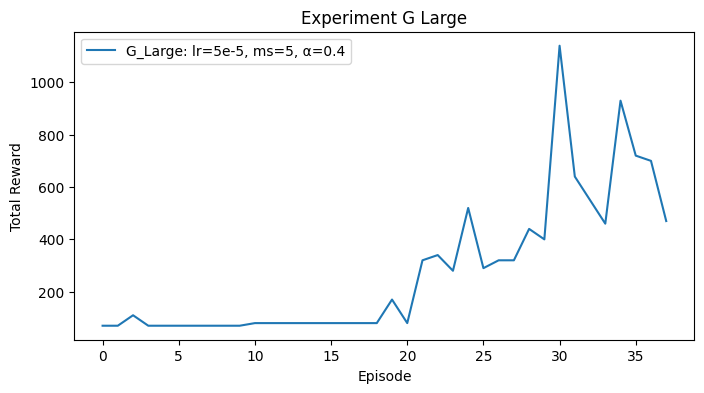

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(rewards_G_large, label='G_Large: lr=5e-5, ms=5, α=0.4')
plt.xlabel('Episode'); plt.ylabel('Total Reward')
plt.title('Experiment G Large')
plt.legend()
plt.show()

In [ ]:
# Experiment H: lr=5e-5, multi_step=5, alpha=0.6 
hparams_H_large = hparams_A.copy()
hparams_H_large['learning_rate'] = 5e-5
hparams_H_large['multi_step'] = 5
hparams_H_large['alpha'] = 0.6
hparams_H_large['buffer_size'] = 1000000
hparams_H_large['update_target_every'] = 5000
hparams_H_large['beta_frames'] = 500000

rewards_H_large = run_experiment(hparams_H_large)
all_results_large['H'] = (hparams_H_large, rewards_H_large)

Training:   2%|▏         | 624/30000 [01:29<1:21:13,  6.03it/s, Episode Reward=60]

Frame: 623, Episode Reward: 60.0


Training:   4%|▍         | 1284/30000 [03:22<1:30:30,  5.29it/s, Episode Reward=80]

Frame: 1283, Episode Reward: 80.0


Training:   6%|▋         | 1903/30000 [05:25<1:29:53,  5.21it/s, Episode Reward=60]

Frame: 1902, Episode Reward: 60.0


Training:   8%|▊         | 2531/30000 [07:36<1:20:59,  5.65it/s, Episode Reward=60]

Frame: 2530, Episode Reward: 60.0


Training:  10%|█         | 3092/30000 [09:19<1:12:54,  6.15it/s, Episode Reward=60]

Frame: 3091, Episode Reward: 60.0


Training:  13%|█▎        | 3886/30000 [11:40<1:15:21,  5.78it/s, Episode Reward=120]

Frame: 3885, Episode Reward: 120.0


Training:  15%|█▌        | 4510/30000 [13:37<1:23:56,  5.06it/s, Episode Reward=100]

Frame: 4509, Episode Reward: 100.0


Training:  17%|█▋        | 5203/30000 [15:59<1:13:03,  5.66it/s, Episode Reward=70] 

Frame: 5202, Episode Reward: 70.0


Training:  19%|█▉        | 5800/30000 [17:56<1:18:40,  5.13it/s, Episode Reward=70]

Frame: 5799, Episode Reward: 70.0


Training:  22%|██▏       | 6475/30000 [20:12<1:27:35,  4.48it/s, Episode Reward=150]

Frame: 6475, Episode Reward: 150.0


Training:  24%|██▍       | 7154/30000 [22:23<1:06:40,  5.71it/s, Episode Reward=190]

Frame: 7153, Episode Reward: 190.0


Training:  26%|██▋       | 7924/30000 [24:40<1:07:21,  5.46it/s, Episode Reward=230]

Frame: 7923, Episode Reward: 230.0


Training:  29%|██▉       | 8770/30000 [27:20<1:09:57,  5.06it/s, Episode Reward=480]

Frame: 8769, Episode Reward: 480.0


Training:  32%|███▏      | 9527/30000 [29:53<1:06:34,  5.13it/s, Episode Reward=320]

Frame: 9526, Episode Reward: 320.0


Training:  34%|███▍      | 10272/30000 [32:22<1:05:06,  5.05it/s, Episode Reward=360]

Frame: 10272, Episode Reward: 360.0


Training:  37%|███▋      | 11117/30000 [35:24<1:10:11,  4.48it/s, Episode Reward=450]

Frame: 11117, Episode Reward: 450.0


Training:  39%|███▉      | 11812/30000 [37:46<1:09:24,  4.37it/s, Episode Reward=460]

Frame: 11812, Episode Reward: 460.0


Training:  42%|████▏     | 12598/30000 [40:23<1:02:29,  4.64it/s, Episode Reward=370]

Frame: 12598, Episode Reward: 370.0


Training:  45%|████▍     | 13410/30000 [43:08<54:33,  5.07it/s, Episode Reward=320]  

Frame: 13409, Episode Reward: 320.0


Training:  48%|████▊     | 14347/30000 [46:15<1:03:27,  4.11it/s, Episode Reward=500]

Frame: 14347, Episode Reward: 500.0


Training:  51%|█████     | 15160/30000 [49:02<47:15,  5.23it/s, Episode Reward=350]  

Frame: 15159, Episode Reward: 350.0


Training:  53%|█████▎    | 15880/30000 [51:12<41:16,  5.70it/s, Episode Reward=330]  

Frame: 15879, Episode Reward: 330.0


Training:  55%|█████▌    | 16543/30000 [53:11<36:05,  6.21it/s, Episode Reward=340]

Frame: 16542, Episode Reward: 340.0


Training:  58%|█████▊    | 17466/30000 [56:06<39:39,  5.27it/s, Episode Reward=430]

Frame: 17466, Episode Reward: 430.0


Training:  61%|██████    | 18154/30000 [58:19<38:47,  5.09it/s, Episode Reward=400]

Frame: 18153, Episode Reward: 400.0


Training:  63%|██████▎   | 18783/30000 [1:00:13<40:51,  4.58it/s, Episode Reward=380]

Frame: 18783, Episode Reward: 380.0


Training:  65%|██████▌   | 19528/30000 [1:02:48<34:33,  5.05it/s, Episode Reward=490]  

Frame: 19528, Episode Reward: 490.0


Training:  68%|██████▊   | 20253/30000 [1:05:05<30:50,  5.27it/s, Episode Reward=380]

Frame: 20252, Episode Reward: 380.0


Training:  71%|███████   | 21172/30000 [1:08:07<29:31,  4.98it/s, Episode Reward=1900.0]

Frame: 21171, Episode Reward: 1900.0


Training:  73%|███████▎  | 21902/30000 [1:10:32<23:00,  5.87it/s, Episode Reward=390]   

Frame: 21901, Episode Reward: 390.0


Training:  75%|███████▌  | 22517/30000 [1:12:36<22:12,  5.61it/s, Episode Reward=300]

Frame: 22516, Episode Reward: 300.0


Training:  77%|███████▋  | 23163/30000 [1:14:46<21:49,  5.22it/s, Episode Reward=420]

Frame: 23162, Episode Reward: 420.0


Training:  80%|████████  | 24060/30000 [1:17:41<19:21,  5.11it/s, Episode Reward=1930.0]

Frame: 24059, Episode Reward: 1930.0


Training:  83%|████████▎ | 24978/30000 [1:20:44<17:07,  4.89it/s, Episode Reward=550]   

Frame: 24978, Episode Reward: 550.0


Training:  86%|████████▌ | 25792/30000 [1:23:38<15:59,  4.38it/s, Episode Reward=490]

Frame: 25792, Episode Reward: 490.0


Training:  88%|████████▊ | 26477/30000 [1:25:48<11:14,  5.22it/s, Episode Reward=390]

Frame: 26476, Episode Reward: 390.0


Training:  91%|█████████ | 27328/30000 [1:28:29<08:33,  5.21it/s, Episode Reward=440]

Frame: 27327, Episode Reward: 440.0


Training:  94%|█████████▍| 28142/30000 [1:31:11<06:04,  5.10it/s, Episode Reward=370]

Frame: 28141, Episode Reward: 370.0


Training:  97%|█████████▋| 29237/30000 [1:34:48<02:32,  5.01it/s, Episode Reward=540]

Frame: 29236, Episode Reward: 540.0


Training: 100%|█████████▉| 29932/30000 [1:37:04<00:12,  5.33it/s, Episode Reward=440]

Frame: 29931, Episode Reward: 440.0


Training: 100%|██████████| 30000/30000 [1:37:17<00:00,  5.14it/s, Episode Reward=440]


▶Training finished!


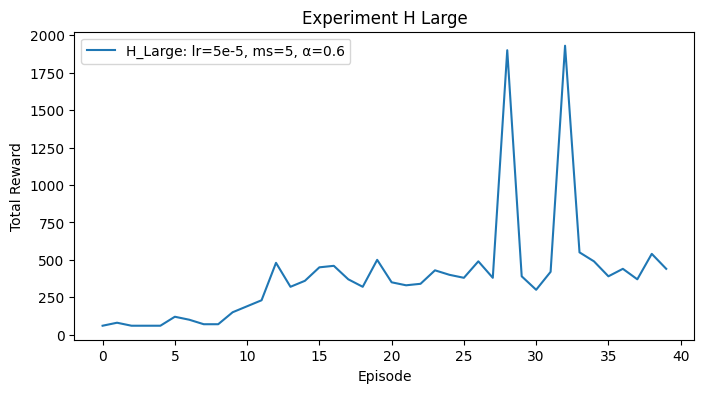

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(rewards_H_large, label='H_Large: lr=5e-5, ms=5, α=0.6')
plt.xlabel('Episode'); plt.ylabel('Total Reward')
plt.title('Experiment H Large')
plt.legend()
plt.show()

In [ ]:
# Example: run Experiment A across 3 seeds
hparams_E_seed = {
    'learning_rate': 5e-5,
    'gamma': 0.99,
    'buffer_size': 1000000,
    'batch_size': 32,
    'multi_step': 3,
    'update_target_every': 5000,
    'alpha': 0.4,
    'beta_start': 0.4,
    'beta_frames': 500000,
    'total_frames': 30000
}
seeds = [0, 1, 2]
runs_E_seed = run_experiment_seeds(hparams_E_seed, seeds)
all_results_seeds['E_seed'] = (hparams_E_seed, runs_E_seed)

Training:   2%|▏         | 546/30000 [01:14<1:22:52,  5.92it/s, Episode Reward=60]

Frame: 545, Episode Reward: 60.0


Training:   4%|▍         | 1187/30000 [02:57<1:16:07,  6.31it/s, Episode Reward=60]

Frame: 1186, Episode Reward: 60.0


Training:   6%|▌         | 1850/30000 [04:45<1:18:02,  6.01it/s, Episode Reward=200]

Frame: 1849, Episode Reward: 200.0


Training:   9%|▉         | 2639/30000 [06:57<1:15:06,  6.07it/s, Episode Reward=520]

Frame: 2638, Episode Reward: 520.0


Training:  11%|█▏        | 3388/30000 [09:06<1:18:35,  5.64it/s, Episode Reward=380]

Frame: 3387, Episode Reward: 380.0


Training:  14%|█▎        | 4084/30000 [11:19<1:14:59,  5.76it/s, Episode Reward=460]

Frame: 4083, Episode Reward: 460.0


Training:  15%|█▍        | 4449/30000 [12:24<1:17:05,  5.52it/s, Episode Reward=140]

Frame: 4448, Episode Reward: 140.0


Training:  16%|█▋        | 4893/30000 [13:48<1:16:02,  5.50it/s, Episode Reward=220]

Frame: 4892, Episode Reward: 220.0


Training:  18%|█▊        | 5378/30000 [15:18<1:15:24,  5.44it/s, Episode Reward=290]

Frame: 5377, Episode Reward: 290.0


Training:  20%|█▉        | 5982/30000 [17:12<1:19:12,  5.05it/s, Episode Reward=300]

Frame: 5981, Episode Reward: 300.0


Training:  23%|██▎       | 6932/30000 [20:11<1:14:18,  5.17it/s, Episode Reward=340]

Frame: 6931, Episode Reward: 340.0


Training:  25%|██▌       | 7531/30000 [22:04<1:10:53,  5.28it/s, Episode Reward=340]

Frame: 7530, Episode Reward: 340.0


Training:  27%|██▋       | 8170/30000 [24:07<1:05:13,  5.58it/s, Episode Reward=220]

Frame: 8169, Episode Reward: 220.0


Training:  29%|██▉       | 8667/30000 [25:42<1:06:57,  5.31it/s, Episode Reward=340]

Frame: 8666, Episode Reward: 340.0


Training:  32%|███▏      | 9502/30000 [28:20<1:08:17,  5.00it/s, Episode Reward=1070.0]

Frame: 9501, Episode Reward: 1070.0


Training:  34%|███▎      | 10083/30000 [30:11<1:04:05,  5.18it/s, Episode Reward=340]   

Frame: 10082, Episode Reward: 340.0


Training:  36%|███▌      | 10717/30000 [32:12<1:02:00,  5.18it/s, Episode Reward=300]

Frame: 10716, Episode Reward: 300.0


Training:  38%|███▊      | 11373/30000 [34:20<56:10,  5.53it/s, Episode Reward=360]  

Frame: 11372, Episode Reward: 360.0


Training:  40%|███▉      | 11938/30000 [36:04<54:28,  5.53it/s, Episode Reward=360]  

Frame: 11937, Episode Reward: 360.0


Training:  42%|████▏     | 12598/30000 [38:08<53:08,  5.46it/s, Episode Reward=400]  

Frame: 12597, Episode Reward: 400.0


Training:  44%|████▍     | 13204/30000 [39:58<51:41,  5.42it/s, Episode Reward=360]

Frame: 13203, Episode Reward: 360.0


Training:  46%|████▌     | 13818/30000 [41:50<47:59,  5.62it/s, Episode Reward=370]

Frame: 13817, Episode Reward: 370.0


Training:  49%|████▉     | 14640/30000 [44:21<46:13,  5.54it/s, Episode Reward=370]  

Frame: 14639, Episode Reward: 370.0


Training:  51%|█████     | 15360/30000 [46:33<42:50,  5.70it/s, Episode Reward=360]

Frame: 15359, Episode Reward: 360.0


Training:  53%|█████▎    | 15915/30000 [48:14<42:37,  5.51it/s, Episode Reward=290]

Frame: 15914, Episode Reward: 290.0


Training:  56%|█████▌    | 16830/30000 [51:00<39:56,  5.50it/s, Episode Reward=460]

Frame: 16829, Episode Reward: 460.0


Training:  58%|█████▊    | 17521/30000 [53:06<37:58,  5.48it/s, Episode Reward=380]

Frame: 17520, Episode Reward: 380.0


Training:  60%|██████    | 18063/30000 [54:46<37:36,  5.29it/s, Episode Reward=310]

Frame: 18063, Episode Reward: 310.0


Training:  62%|██████▏   | 18718/30000 [56:48<33:45,  5.57it/s, Episode Reward=380]

Frame: 18717, Episode Reward: 380.0


Training:  65%|██████▍   | 19374/30000 [58:49<32:33,  5.44it/s, Episode Reward=420]

Frame: 19373, Episode Reward: 420.0


Training:  66%|██████▋   | 19926/30000 [1:00:29<30:32,  5.50it/s, Episode Reward=370]

Frame: 19925, Episode Reward: 370.0


Training:  68%|██████▊   | 20356/30000 [1:01:48<31:22,  5.12it/s, Episode Reward=160]

Frame: 20355, Episode Reward: 160.0


Training:  70%|███████   | 21005/30000 [1:03:47<27:32,  5.44it/s, Episode Reward=370]

Frame: 21004, Episode Reward: 370.0


Training:  72%|███████▏  | 21486/30000 [1:05:19<26:00,  5.46it/s, Episode Reward=160]

Frame: 21485, Episode Reward: 160.0


Training:  74%|███████▎  | 22080/30000 [1:07:07<24:34,  5.37it/s, Episode Reward=430]

Frame: 22079, Episode Reward: 430.0


Training:  76%|███████▌  | 22762/30000 [1:09:13<22:21,  5.40it/s, Episode Reward=300]

Frame: 22761, Episode Reward: 300.0


Training:  78%|███████▊  | 23441/30000 [1:11:17<20:17,  5.39it/s, Episode Reward=300]

Frame: 23440, Episode Reward: 300.0


Training:  80%|████████  | 24080/30000 [1:13:17<18:24,  5.36it/s, Episode Reward=280]

Frame: 24079, Episode Reward: 280.0


Training:  82%|████████▏ | 24504/30000 [1:14:35<17:20,  5.28it/s, Episode Reward=140]

Frame: 24503, Episode Reward: 140.0


Training:  84%|████████▎ | 25075/30000 [1:16:21<14:51,  5.52it/s, Episode Reward=370]

Frame: 25074, Episode Reward: 370.0


Training:  86%|████████▌ | 25736/30000 [1:18:23<13:12,  5.38it/s, Episode Reward=360]

Frame: 25735, Episode Reward: 360.0


Training:  88%|████████▊ | 26385/30000 [1:20:22<11:13,  5.37it/s, Episode Reward=370]

Frame: 26384, Episode Reward: 370.0


Training:  90%|█████████ | 27079/30000 [1:22:29<09:01,  5.39it/s, Episode Reward=370]

Frame: 27078, Episode Reward: 370.0


Training:  92%|█████████▏| 27718/30000 [1:24:28<07:02,  5.40it/s, Episode Reward=370]

Frame: 27717, Episode Reward: 370.0


Training:  95%|█████████▍| 28378/30000 [1:26:28<04:53,  5.53it/s, Episode Reward=340]

Frame: 28377, Episode Reward: 340.0


Training:  96%|█████████▋| 28900/30000 [1:28:05<03:30,  5.23it/s, Episode Reward=320]

Frame: 28899, Episode Reward: 320.0


Training:  98%|█████████▊| 29354/30000 [1:29:28<01:57,  5.51it/s, Episode Reward=310]

Frame: 29353, Episode Reward: 310.0


Training: 100%|█████████▉| 29896/30000 [1:31:11<00:18,  5.60it/s, Episode Reward=280]

Frame: 29895, Episode Reward: 280.0


Training: 100%|██████████| 30000/30000 [1:31:31<00:00,  5.46it/s, Episode Reward=280]


▶Training finished!


Training:   3%|▎         | 987/30000 [02:42<1:29:17,  5.41it/s, Episode Reward=210]

Frame: 986, Episode Reward: 210.0


Training:   6%|▋         | 1901/30000 [05:16<1:18:17,  5.98it/s, Episode Reward=250]

Frame: 1900, Episode Reward: 250.0


Training:  10%|▉         | 2919/30000 [08:08<1:11:49,  6.28it/s, Episode Reward=250]

Frame: 2918, Episode Reward: 250.0


Training:  13%|█▎        | 4036/30000 [11:18<1:12:34,  5.96it/s, Episode Reward=560]

Frame: 4035, Episode Reward: 560.0


Training:  17%|█▋        | 5023/30000 [14:03<1:11:18,  5.84it/s, Episode Reward=600]

Frame: 5022, Episode Reward: 600.0


Training:  19%|█▉        | 5839/30000 [16:20<1:09:34,  5.79it/s, Episode Reward=320]

Frame: 5838, Episode Reward: 320.0


Training:  25%|██▍       | 7362/30000 [20:35<1:02:59,  5.99it/s, Episode Reward=290]

Frame: 7361, Episode Reward: 290.0


Training:  30%|██▉       | 8938/30000 [25:01<57:43,  6.08it/s, Episode Reward=220]  

Frame: 8937, Episode Reward: 220.0


Training:  35%|███▌      | 10529/30000 [29:30<55:35,  5.84it/s, Episode Reward=520]  

Frame: 10528, Episode Reward: 520.0


Training:  37%|███▋      | 11179/30000 [31:18<1:04:31,  4.86it/s, Episode Reward=420]

Frame: 11179, Episode Reward: 420.0


Training:  40%|████      | 12069/30000 [33:49<48:54,  6.11it/s, Episode Reward=420]  

Frame: 12068, Episode Reward: 420.0


Training:  47%|████▋     | 14085/30000 [39:26<43:15,  6.13it/s, Episode Reward=560]  

Frame: 14084, Episode Reward: 560.0


Training:  52%|█████▏    | 15599/30000 [43:36<40:33,  5.92it/s, Episode Reward=720]

Frame: 15598, Episode Reward: 720.0


Training:  55%|█████▍    | 16469/30000 [46:01<36:09,  6.24it/s, Episode Reward=450]

Frame: 16468, Episode Reward: 450.0


Training:  57%|█████▋    | 17052/30000 [47:38<35:23,  6.10it/s, Episode Reward=400]

Frame: 17051, Episode Reward: 400.0


Training:  60%|██████    | 18105/30000 [50:31<32:42,  6.06it/s, Episode Reward=450]

Frame: 18104, Episode Reward: 450.0


Training:  63%|██████▎   | 18816/30000 [52:32<29:25,  6.34it/s, Episode Reward=610]

Frame: 18815, Episode Reward: 610.0


Training:  66%|██████▌   | 19727/30000 [55:03<29:34,  5.79it/s, Episode Reward=500]

Frame: 19726, Episode Reward: 500.0


Training:  68%|██████▊   | 20516/30000 [57:14<26:43,  5.91it/s, Episode Reward=450]

Frame: 20515, Episode Reward: 450.0


Training:  71%|███████   | 21222/30000 [59:11<24:20,  6.01it/s, Episode Reward=610]

Frame: 21221, Episode Reward: 610.0


Training:  73%|███████▎  | 21866/30000 [1:00:58<22:00,  6.16it/s, Episode Reward=380]

Frame: 21865, Episode Reward: 380.0


Training:  75%|███████▌  | 22590/30000 [1:02:58<20:11,  6.11it/s, Episode Reward=510]

Frame: 22589, Episode Reward: 510.0


Training:  78%|███████▊  | 23366/30000 [1:05:11<19:13,  5.75it/s, Episode Reward=380]

Frame: 23365, Episode Reward: 380.0


Training:  81%|████████  | 24309/30000 [1:07:48<15:47,  6.01it/s, Episode Reward=460]

Frame: 24308, Episode Reward: 460.0


Training:  83%|████████▎ | 24964/30000 [1:09:40<13:54,  6.03it/s, Episode Reward=380]

Frame: 24963, Episode Reward: 380.0


Training:  85%|████████▌ | 25644/30000 [1:11:34<12:45,  5.69it/s, Episode Reward=590]

Frame: 25643, Episode Reward: 590.0


Training:  87%|████████▋ | 26246/30000 [1:13:13<10:16,  6.09it/s, Episode Reward=530]

Frame: 26245, Episode Reward: 530.0


Training:  90%|█████████ | 27042/30000 [1:15:29<08:31,  5.79it/s, Episode Reward=660]

Frame: 27041, Episode Reward: 660.0


Training:  92%|█████████▏| 27748/30000 [1:17:26<06:14,  6.01it/s, Episode Reward=630]

Frame: 27747, Episode Reward: 630.0


Training:  95%|█████████▍| 28466/30000 [1:19:27<04:15,  6.01it/s, Episode Reward=620]

Frame: 28465, Episode Reward: 620.0


Training:  98%|█████████▊| 29358/30000 [1:21:55<01:46,  6.02it/s, Episode Reward=630]

Frame: 29357, Episode Reward: 630.0


Training: 100%|██████████| 30000/30000 [1:23:42<00:00,  5.97it/s, Episode Reward=630]


▶Training finished!


Training:   2%|▏         | 646/30000 [01:38<1:17:19,  6.33it/s, Episode Reward=60]

Frame: 645, Episode Reward: 60.0


Training:   5%|▌         | 1539/30000 [04:04<1:16:06,  6.23it/s, Episode Reward=380]

Frame: 1538, Episode Reward: 380.0


Training:   8%|▊         | 2289/30000 [06:09<1:26:10,  5.36it/s, Episode Reward=290]

Frame: 2288, Episode Reward: 290.0


Training:  10%|▉         | 2955/30000 [07:59<1:11:37,  6.29it/s, Episode Reward=220]

Frame: 2954, Episode Reward: 220.0


Training:  12%|█▏        | 3598/30000 [09:44<1:12:06,  6.10it/s, Episode Reward=220]

Frame: 3597, Episode Reward: 220.0


Training:  14%|█▍        | 4223/30000 [11:27<1:09:43,  6.16it/s, Episode Reward=240]

Frame: 4222, Episode Reward: 240.0


Training:  16%|█▋        | 4889/30000 [13:16<1:11:52,  5.82it/s, Episode Reward=220]

Frame: 4888, Episode Reward: 220.0


Training:  19%|█▉        | 5789/30000 [15:45<1:04:22,  6.27it/s, Episode Reward=450]

Frame: 5788, Episode Reward: 450.0


Training:  23%|██▎       | 6759/30000 [18:23<1:02:03,  6.24it/s, Episode Reward=290]

Frame: 6758, Episode Reward: 290.0


Training:  26%|██▌       | 7713/30000 [20:56<59:46,  6.21it/s, Episode Reward=1690.0]

Frame: 7712, Episode Reward: 1690.0


Training:  28%|██▊       | 8543/30000 [23:11<55:14,  6.47it/s, Episode Reward=490]     

Frame: 8542, Episode Reward: 490.0


Training:  32%|███▏      | 9500/30000 [25:45<55:43,  6.13it/s, Episode Reward=480]  

Frame: 9499, Episode Reward: 480.0


Training:  35%|███▍      | 10401/30000 [28:10<53:17,  6.13it/s, Episode Reward=520]  

Frame: 10400, Episode Reward: 520.0


Training:  38%|███▊      | 11460/30000 [31:01<51:03,  6.05it/s, Episode Reward=310]  

Frame: 11459, Episode Reward: 310.0


Training:  41%|████      | 12223/30000 [33:04<49:11,  6.02it/s, Episode Reward=310]

Frame: 12222, Episode Reward: 310.0


Training:  43%|████▎     | 12909/30000 [34:55<46:53,  6.08it/s, Episode Reward=440]

Frame: 12908, Episode Reward: 440.0


Training:  45%|████▌     | 13631/30000 [36:53<44:46,  6.09it/s, Episode Reward=350]

Frame: 13630, Episode Reward: 350.0


Training:  49%|████▊     | 14578/30000 [39:28<41:41,  6.16it/s, Episode Reward=930]

Frame: 14577, Episode Reward: 930.0


Training:  51%|█████     | 15267/30000 [41:20<39:18,  6.25it/s, Episode Reward=330]

Frame: 15266, Episode Reward: 330.0


Training:  53%|█████▎    | 16008/30000 [43:20<37:24,  6.23it/s, Episode Reward=240]

Frame: 16007, Episode Reward: 240.0


Training:  56%|█████▌    | 16793/30000 [45:27<35:37,  6.18it/s, Episode Reward=520]

Frame: 16792, Episode Reward: 520.0


Training:  59%|█████▉    | 17679/30000 [47:53<32:53,  6.24it/s, Episode Reward=590]

Frame: 17678, Episode Reward: 590.0


Training:  62%|██████▏   | 18657/30000 [50:31<29:37,  6.38it/s, Episode Reward=580]

Frame: 18656, Episode Reward: 580.0


Training:  65%|██████▍   | 19491/30000 [52:46<28:32,  6.13it/s, Episode Reward=380]

Frame: 19490, Episode Reward: 380.0


Training:  68%|██████▊   | 20332/30000 [55:03<25:49,  6.24it/s, Episode Reward=490]

Frame: 20331, Episode Reward: 490.0


Training:  70%|███████   | 21130/30000 [57:12<24:57,  5.92it/s, Episode Reward=250]

Frame: 21129, Episode Reward: 250.0


Training:  73%|███████▎  | 22021/30000 [59:37<21:21,  6.23it/s, Episode Reward=570]

Frame: 22020, Episode Reward: 570.0


Training:  76%|███████▋  | 22896/30000 [1:02:00<20:01,  5.91it/s, Episode Reward=520]

Frame: 22895, Episode Reward: 520.0


Training:  79%|███████▉  | 23751/30000 [1:04:18<16:46,  6.21it/s, Episode Reward=900]

Frame: 23750, Episode Reward: 900.0


Training:  82%|████████▏ | 24603/30000 [1:06:36<14:58,  6.00it/s, Episode Reward=540]

Frame: 24602, Episode Reward: 540.0


Training:  85%|████████▌ | 25590/30000 [1:09:16<11:59,  6.13it/s, Episode Reward=490]

Frame: 25589, Episode Reward: 490.0


Training:  88%|████████▊ | 26457/30000 [1:11:38<09:31,  6.20it/s, Episode Reward=490]

Frame: 26456, Episode Reward: 490.0


Training:  91%|█████████ | 27348/30000 [1:14:02<06:59,  6.33it/s, Episode Reward=600]

Frame: 27347, Episode Reward: 600.0


Training:  94%|█████████▍| 28139/30000 [1:16:11<05:12,  5.95it/s, Episode Reward=320]

Frame: 28138, Episode Reward: 320.0


Training:  96%|█████████▌| 28698/30000 [1:17:43<03:32,  6.13it/s, Episode Reward=250]

Frame: 28697, Episode Reward: 250.0


Training:  99%|█████████▉| 29722/30000 [1:20:30<00:44,  6.23it/s, Episode Reward=580]

Frame: 29721, Episode Reward: 580.0


Training: 100%|██████████| 30000/30000 [1:21:15<00:00,  6.15it/s, Episode Reward=580]


▶Training finished!


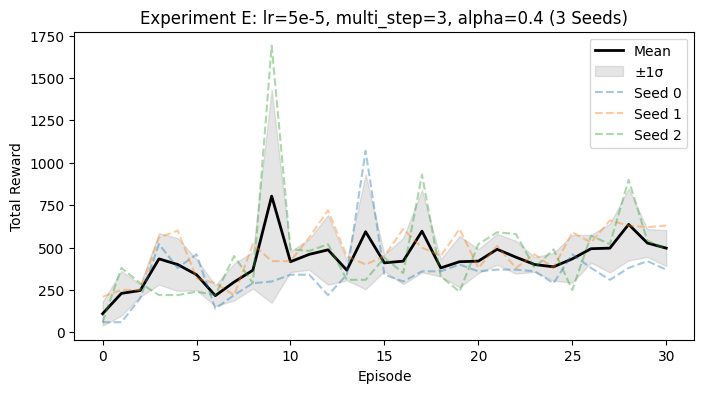

In [ ]:
min_len = min(len(r) for r in runs_E_seed)
runs_trunc = [r[:min_len] for r in runs_E_seed]

episodes = np.arange(min_len)
mean_rewards = np.mean(runs_trunc, axis=0)
std_rewards  = np.std(runs_trunc, axis=0)

plt.figure(figsize=(8,4))
plt.plot(episodes, mean_rewards, color='black', linewidth=2, label='Mean')
plt.fill_between(
    episodes,
    mean_rewards - std_rewards,
    mean_rewards + std_rewards,
    color='gray',
    alpha=0.2,
    label='±1σ'
)

for i, r in enumerate(runs_trunc):
    plt.plot(episodes, r, linestyle='--', alpha=0.4, label=f"Seed {seeds[i]}")

plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Experiment E: lr=5e-5, multi_step=3, alpha=0.4 (3 Seeds)")
plt.legend()
plt.show()

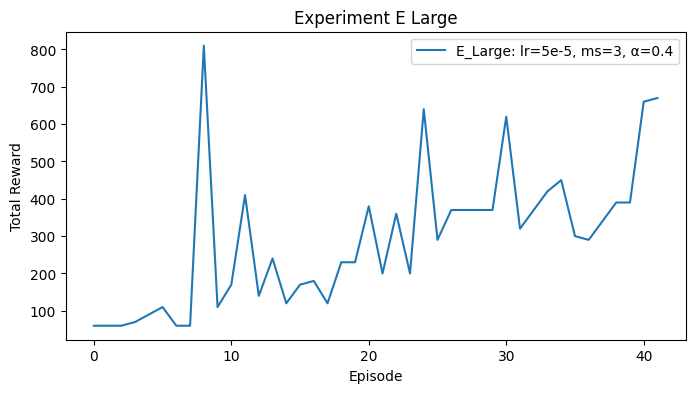

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(rewards_E_large, label='E_Large: lr=5e-5, ms=3, α=0.4')
plt.xlabel('Episode'); plt.ylabel('Total Reward')
plt.title('Experiment E Large')
plt.legend()
plt.show()

In [ ]:
#Choose Better performance to test large 
# 'buffer_size': 100000 -> 1000000
#'update_target_every': 1000 -> 5000
#'beta_frames': 100000 ->500000
# Experiment F: lr=5e-5, multi_step=3, alpha=0.6 
hparams_F_large = hparams_A.copy()
hparams_F_large['learning_rate'] = 5e-5
hparams_F_large['alpha'] = 0.6
hparams_F_large['buffer_size'] = 1000000
hparams_F_large['update_target_every'] = 5000
hparams_F_large['beta_frames'] = 500000

rewards_F_large = run_experiment(hparams_F_large)
all_results_large['F'] = (hparams_F_large, rewards_F_large)

Training:   2%|▏         | 507/30000 [01:00<59:46,  8.22it/s, Episode Reward=210]

Frame: 506, Episode Reward: 210.0


Training:   4%|▎         | 1111/30000 [02:23<1:10:07,  6.87it/s, Episode Reward=400]

Frame: 1110, Episode Reward: 400.0


Training:   6%|▌         | 1804/30000 [04:05<1:08:26,  6.87it/s, Episode Reward=220]

Frame: 1803, Episode Reward: 220.0


Training:   8%|▊         | 2342/30000 [05:29<1:13:11,  6.30it/s, Episode Reward=220]

Frame: 2341, Episode Reward: 220.0


Training:  10%|▉         | 2879/30000 [07:03<1:20:51,  5.59it/s, Episode Reward=230]

Frame: 2878, Episode Reward: 230.0


Training:  11%|█▏        | 3397/30000 [08:33<1:19:12,  5.60it/s, Episode Reward=240]

Frame: 3396, Episode Reward: 240.0


Training:  13%|█▎        | 3932/30000 [10:07<1:16:34,  5.67it/s, Episode Reward=320]

Frame: 3931, Episode Reward: 320.0


Training:  16%|█▋        | 4886/30000 [12:57<1:07:34,  6.19it/s, Episode Reward=450]

Frame: 4885, Episode Reward: 450.0


Training:  19%|█▊        | 5594/30000 [15:05<1:16:28,  5.32it/s, Episode Reward=420]

Frame: 5593, Episode Reward: 420.0


Training:  21%|██        | 6243/30000 [16:55<1:09:03,  5.73it/s, Episode Reward=390]

Frame: 6242, Episode Reward: 390.0


Training:  23%|██▎       | 6863/30000 [18:44<1:13:52,  5.22it/s, Episode Reward=320]

Frame: 6863, Episode Reward: 320.0


Training:  25%|██▌       | 7644/30000 [21:15<1:12:31,  5.14it/s, Episode Reward=310]

Frame: 7643, Episode Reward: 310.0


Training:  28%|██▊       | 8329/30000 [23:18<1:00:51,  5.93it/s, Episode Reward=300]

Frame: 8328, Episode Reward: 300.0


Training:  30%|██▉       | 8978/30000 [25:12<1:04:30,  5.43it/s, Episode Reward=360]

Frame: 8977, Episode Reward: 360.0


Training:  32%|███▏      | 9560/30000 [26:59<1:06:55,  5.09it/s, Episode Reward=360]

Frame: 9560, Episode Reward: 360.0


Training:  34%|███▍      | 10338/30000 [29:21<57:55,  5.66it/s, Episode Reward=470]  

Frame: 10337, Episode Reward: 470.0


Training:  37%|███▋      | 11068/30000 [31:32<54:31,  5.79it/s, Episode Reward=430]  

Frame: 11067, Episode Reward: 430.0


Training:  39%|███▉      | 11727/30000 [33:34<51:46,  5.88it/s, Episode Reward=530]  

Frame: 11726, Episode Reward: 530.0


Training:  42%|████▏     | 12562/30000 [36:30<1:04:33,  4.50it/s, Episode Reward=360]

Frame: 12561, Episode Reward: 360.0


Training:  44%|████▎     | 13101/30000 [38:25<1:00:56,  4.62it/s, Episode Reward=300]

Frame: 13101, Episode Reward: 300.0


Training:  46%|████▌     | 13694/30000 [40:30<54:18,  5.00it/s, Episode Reward=320]  

Frame: 13693, Episode Reward: 320.0


Training:  48%|████▊     | 14431/30000 [42:54<51:13,  5.07it/s, Episode Reward=310]  

Frame: 14430, Episode Reward: 310.0


Training:  50%|█████     | 15061/30000 [45:00<49:11,  5.06it/s, Episode Reward=310]  

Frame: 15061, Episode Reward: 310.0


Training:  53%|█████▎    | 15810/30000 [47:34<48:56,  4.83it/s, Episode Reward=310]  

Frame: 15810, Episode Reward: 310.0


Training:  55%|█████▍    | 16388/30000 [49:43<49:44,  4.56it/s, Episode Reward=290]  

Frame: 16388, Episode Reward: 290.0


Training:  57%|█████▋    | 17201/30000 [52:39<41:38,  5.12it/s, Episode Reward=380]  

Frame: 17201, Episode Reward: 380.0


Training:  59%|█████▉    | 17792/30000 [54:36<40:20,  5.04it/s, Episode Reward=290]

Frame: 17791, Episode Reward: 290.0


Training:  61%|██████▏   | 18424/30000 [56:29<34:55,  5.52it/s, Episode Reward=290]

Frame: 18423, Episode Reward: 290.0


Training:  64%|██████▎   | 19116/30000 [58:32<33:12,  5.46it/s, Episode Reward=520]

Frame: 19115, Episode Reward: 520.0


Training:  66%|██████▌   | 19866/30000 [1:00:50<30:28,  5.54it/s, Episode Reward=520]

Frame: 19865, Episode Reward: 520.0


Training:  69%|██████▉   | 20732/30000 [1:03:28<28:42,  5.38it/s, Episode Reward=520]

Frame: 20731, Episode Reward: 520.0


Training:  72%|███████▏  | 21519/30000 [1:05:53<25:42,  5.50it/s, Episode Reward=480]

Frame: 21518, Episode Reward: 480.0


Training:  74%|███████▍  | 22211/30000 [1:08:00<24:59,  5.19it/s, Episode Reward=350]

Frame: 22210, Episode Reward: 350.0


Training:  76%|███████▋  | 22938/30000 [1:10:14<22:34,  5.21it/s, Episode Reward=440]

Frame: 22937, Episode Reward: 440.0


Training:  79%|███████▊  | 23619/30000 [1:12:23<19:16,  5.52it/s, Episode Reward=320]

Frame: 23618, Episode Reward: 320.0


Training:  81%|████████  | 24254/30000 [1:14:22<17:22,  5.51it/s, Episode Reward=330]

Frame: 24253, Episode Reward: 330.0


Training:  84%|████████▍ | 25217/30000 [1:17:22<14:34,  5.47it/s, Episode Reward=300]

Frame: 25216, Episode Reward: 300.0


Training:  86%|████████▋ | 25877/30000 [1:19:26<12:26,  5.52it/s, Episode Reward=380]

Frame: 25876, Episode Reward: 380.0


Training:  89%|████████▊ | 26619/30000 [1:21:49<11:02,  5.10it/s, Episode Reward=420]

Frame: 26619, Episode Reward: 420.0


Training:  91%|█████████ | 27181/30000 [1:23:45<10:02,  4.68it/s, Episode Reward=390]

Frame: 27181, Episode Reward: 390.0


Training:  93%|█████████▎| 27913/30000 [1:26:10<06:42,  5.19it/s, Episode Reward=310]

Frame: 27912, Episode Reward: 310.0


Training:  95%|█████████▍| 28476/30000 [1:27:55<04:37,  5.50it/s, Episode Reward=290]

Frame: 28475, Episode Reward: 290.0


Training:  97%|█████████▋| 29164/30000 [1:30:05<02:33,  5.45it/s, Episode Reward=500]

Frame: 29163, Episode Reward: 500.0


Training: 100%|█████████▉| 29919/30000 [1:32:28<00:15,  5.18it/s, Episode Reward=310]

Frame: 29919, Episode Reward: 310.0


Training: 100%|██████████| 30000/30000 [1:32:44<00:00,  5.39it/s, Episode Reward=310]

▶Training finished!


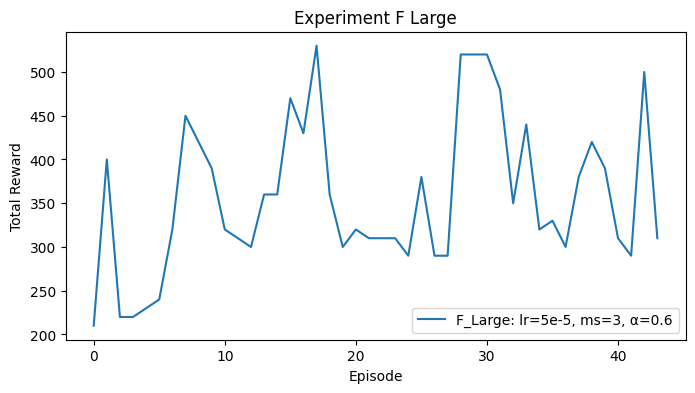

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(rewards_F_large, label='F_Large: lr=5e-5, ms=3, α=0.6')
plt.xlabel('Episode'); plt.ylabel('Total Reward')
plt.title('Experiment F Large')
plt.legend()
plt.show()

In [ ]:
all_results_large['E'] = (hparams_E_large, rewards_E_large)

In [ ]:
all_results_large['G'] = (hparams_G_large, rewards_G_large)

In [ ]:
all_results_large['H'] = (hparams_H_large, rewards_H_large)

In [ ]:
# Experiment A: lr=1e-5, multi_step=3, alpha=0.6 
hparams_A_large = hparams_A.copy()
hparams_A_large['buffer_size'] = 1000000
hparams_A_large['update_target_every'] = 5000
hparams_A_large['beta_frames'] = 500000

rewards_A_large = run_experiment(hparams_A_large)

Training:   2%|▏         | 620/30000 [01:34<1:22:49,  5.91it/s, Episode Reward=60]

Frame: 619, Episode Reward: 60.0


Training:   4%|▍         | 1248/30000 [03:40<1:45:35,  4.54it/s, Episode Reward=60]

Frame: 1248, Episode Reward: 60.0


Training:   6%|▋         | 1876/30000 [05:49<1:36:36,  4.85it/s, Episode Reward=60]

Frame: 1876, Episode Reward: 60.0


Training:   8%|▊         | 2498/30000 [08:01<1:32:42,  4.94it/s, Episode Reward=60]

Frame: 2497, Episode Reward: 60.0


Training:  10%|█         | 3124/30000 [10:09<1:24:33,  5.30it/s, Episode Reward=60]

Frame: 3123, Episode Reward: 60.0


Training:  12%|█▏        | 3734/30000 [12:08<1:25:02,  5.15it/s, Episode Reward=60]

Frame: 3734, Episode Reward: 60.0


Training:  15%|█▍        | 4362/30000 [14:12<1:24:49,  5.04it/s, Episode Reward=60]

Frame: 4361, Episode Reward: 60.0


Training:  17%|█▋        | 4987/30000 [16:16<1:24:37,  4.93it/s, Episode Reward=60]

Frame: 4986, Episode Reward: 60.0


Training:  19%|█▊        | 5600/30000 [18:21<1:15:25,  5.39it/s, Episode Reward=60]

Frame: 5600, Episode Reward: 60.0


Training:  20%|██        | 6083/30000 [19:46<1:13:30,  5.42it/s, Episode Reward=70]

Frame: 6082, Episode Reward: 70.0


Training:  22%|██▏       | 6540/30000 [21:11<1:29:02,  4.39it/s, Episode Reward=70]

Frame: 6540, Episode Reward: 70.0


Training:  23%|██▎       | 7018/30000 [22:36<1:06:02,  5.80it/s, Episode Reward=70]

Frame: 7017, Episode Reward: 70.0


Training:  26%|██▌       | 7726/30000 [24:38<1:03:46,  5.82it/s, Episode Reward=70]

Frame: 7725, Episode Reward: 70.0


Training:  28%|██▊       | 8422/30000 [26:33<1:01:29,  5.85it/s, Episode Reward=70]

Frame: 8421, Episode Reward: 70.0


Training:  30%|███       | 9127/30000 [28:36<1:00:09,  5.78it/s, Episode Reward=70]

Frame: 9126, Episode Reward: 70.0


Training:  32%|███▏      | 9611/30000 [30:04<1:00:35,  5.61it/s, Episode Reward=70]

Frame: 9611, Episode Reward: 70.0


Training:  34%|███▎      | 10090/30000 [31:26<1:00:44,  5.46it/s, Episode Reward=70]

Frame: 10089, Episode Reward: 70.0


Training:  36%|███▌      | 10801/30000 [33:31<56:45,  5.64it/s, Episode Reward=70]  

Frame: 10800, Episode Reward: 70.0


Training:  38%|███▊      | 11283/30000 [34:54<51:28,  6.06it/s, Episode Reward=70]  

Frame: 11282, Episode Reward: 70.0


Training:  39%|███▉      | 11765/30000 [36:12<52:10,  5.82it/s, Episode Reward=70]

Frame: 11764, Episode Reward: 70.0


Training:  41%|████      | 12300/30000 [37:42<47:04,  6.27it/s, Episode Reward=80]  

Frame: 12299, Episode Reward: 80.0


Training:  43%|████▎     | 12778/30000 [39:06<52:26,  5.47it/s, Episode Reward=80]  

Frame: 12777, Episode Reward: 80.0


Training:  44%|████▍     | 13324/30000 [40:38<47:06,  5.90it/s, Episode Reward=70]  

Frame: 13323, Episode Reward: 70.0


Training:  46%|████▌     | 13806/30000 [42:00<45:36,  5.92it/s, Episode Reward=80]  

Frame: 13805, Episode Reward: 80.0


Training:  48%|████▊     | 14345/30000 [43:32<43:44,  5.96it/s, Episode Reward=80]

Frame: 14344, Episode Reward: 80.0


Training:  50%|█████     | 15001/30000 [45:23<42:56,  5.82it/s, Episode Reward=120]

Frame: 15000, Episode Reward: 120.0


Training:  52%|█████▏    | 15579/30000 [47:01<40:01,  6.00it/s, Episode Reward=120]

Frame: 15578, Episode Reward: 120.0


Training:  54%|█████▍    | 16205/30000 [48:47<37:58,  6.05it/s, Episode Reward=120]

Frame: 16204, Episode Reward: 120.0


Training:  56%|█████▌    | 16815/30000 [50:33<36:01,  6.10it/s, Episode Reward=120]

Frame: 16814, Episode Reward: 120.0


Training:  59%|█████▉    | 17718/30000 [53:07<36:07,  5.67it/s, Episode Reward=170]

Frame: 17717, Episode Reward: 170.0


Training:  61%|██████▏   | 18408/30000 [55:06<33:47,  5.72it/s, Episode Reward=120]

Frame: 18407, Episode Reward: 120.0


Training:  64%|██████▍   | 19252/30000 [57:37<28:23,  6.31it/s, Episode Reward=120]

Frame: 19251, Episode Reward: 120.0


Training:  66%|██████▋   | 19913/30000 [59:29<29:21,  5.73it/s, Episode Reward=120]

Frame: 19912, Episode Reward: 120.0


Training:  69%|██████▊   | 20598/30000 [1:01:28<27:32,  5.69it/s, Episode Reward=120]

Frame: 20597, Episode Reward: 120.0


Training:  71%|███████▏  | 21397/30000 [1:03:49<26:31,  5.40it/s, Episode Reward=120]

Frame: 21396, Episode Reward: 120.0


Training:  73%|███████▎  | 21952/30000 [1:05:23<31:22,  4.28it/s, Episode Reward=120]

Frame: 21952, Episode Reward: 120.0


Training:  76%|███████▌  | 22664/30000 [1:07:25<21:26,  5.70it/s, Episode Reward=120]

Frame: 22663, Episode Reward: 120.0


Training:  78%|███████▊  | 23365/30000 [1:09:22<18:29,  5.98it/s, Episode Reward=120]

Frame: 23364, Episode Reward: 120.0


Training:  81%|████████  | 24243/30000 [1:11:47<14:46,  6.50it/s, Episode Reward=170]

Frame: 24242, Episode Reward: 170.0


Training:  83%|████████▎ | 24785/30000 [1:13:17<14:52,  5.84it/s, Episode Reward=120]

Frame: 24784, Episode Reward: 120.0


Training:  85%|████████▍ | 25451/30000 [1:15:08<13:14,  5.72it/s, Episode Reward=120]

Frame: 25450, Episode Reward: 120.0


Training:  86%|████████▋ | 25946/30000 [1:16:30<11:20,  5.96it/s, Episode Reward=120]

Frame: 25945, Episode Reward: 120.0


Training:  89%|████████▉ | 26701/30000 [1:18:38<12:10,  4.52it/s, Episode Reward=120]

Frame: 26701, Episode Reward: 120.0


Training:  91%|█████████▏| 27413/30000 [1:20:39<07:05,  6.08it/s, Episode Reward=120]

Frame: 27412, Episode Reward: 120.0


Training:  93%|█████████▎| 27916/30000 [1:22:03<05:39,  6.14it/s, Episode Reward=120]

Frame: 27915, Episode Reward: 120.0


Training:  95%|█████████▍| 28481/30000 [1:23:38<04:11,  6.04it/s, Episode Reward=120]

Frame: 28480, Episode Reward: 120.0


Training:  97%|█████████▋| 28997/30000 [1:25:05<02:42,  6.15it/s, Episode Reward=120]

Frame: 28996, Episode Reward: 120.0


Training:  99%|█████████▊| 29595/30000 [1:26:50<01:11,  5.63it/s, Episode Reward=120]

Frame: 29594, Episode Reward: 120.0


Training: 100%|██████████| 30000/30000 [1:28:04<00:00,  5.68it/s, Episode Reward=120]


▶Training finished!


In [ ]:
all_results_large['A'] = (hparams_A_large, rewards_A_large)

In [ ]:
# Experiment B large: lr=1e-5, multi_step=3, alpha=0.6 
hparams_B_large = hparams_A.copy()
hparams_B_large['alpha'] = 0.6
hparams_B_large['buffer_size'] = 1000000
hparams_B_large['update_target_every'] = 5000
hparams_B_large['beta_frames'] = 500000

rewards_B_large = run_experiment(hparams_B_large)

Training:   2%|▏         | 652/30000 [01:13<58:03,  8.42it/s, Episode Reward=60]

Frame: 651, Episode Reward: 60.0


Training:   4%|▍         | 1306/30000 [02:40<1:07:53,  7.04it/s, Episode Reward=60]

Frame: 1305, Episode Reward: 60.0


Training:   7%|▋         | 1952/30000 [04:08<1:05:23,  7.15it/s, Episode Reward=60]

Frame: 1951, Episode Reward: 60.0


Training:   8%|▊         | 2546/30000 [05:31<1:09:02,  6.63it/s, Episode Reward=110]

Frame: 2545, Episode Reward: 110.0


Training:  11%|█         | 3190/30000 [07:03<1:02:43,  7.12it/s, Episode Reward=60] 

Frame: 3189, Episode Reward: 60.0


Training:  13%|█▎        | 3801/30000 [08:32<1:00:33,  7.21it/s, Episode Reward=110]

Frame: 3800, Episode Reward: 110.0


Training:  15%|█▌        | 4631/30000 [10:39<1:01:03,  6.93it/s, Episode Reward=180]

Frame: 4630, Episode Reward: 180.0


Training:  18%|█▊        | 5499/30000 [12:46<1:00:51,  6.71it/s, Episode Reward=180]

Frame: 5498, Episode Reward: 180.0


Training:  22%|██▏       | 6582/30000 [15:27<59:33,  6.55it/s, Episode Reward=180]  

Frame: 6581, Episode Reward: 180.0


Training:  25%|██▍       | 7372/30000 [17:27<56:45,  6.64it/s, Episode Reward=230]  

Frame: 7371, Episode Reward: 230.0


Training:  27%|██▋       | 8185/30000 [19:33<53:19,  6.82it/s, Episode Reward=290]  

Frame: 8184, Episode Reward: 290.0


Training:  30%|███       | 9004/30000 [21:40<56:19,  6.21it/s, Episode Reward=230]  

Frame: 9003, Episode Reward: 230.0


Training:  32%|███▏      | 9704/30000 [23:34<55:13,  6.13it/s, Episode Reward=310]  

Frame: 9703, Episode Reward: 310.0


Training:  35%|███▌      | 10523/30000 [25:41<51:34,  6.29it/s, Episode Reward=230]  

Frame: 10522, Episode Reward: 230.0


Training:  38%|███▊      | 11377/30000 [27:57<47:22,  6.55it/s, Episode Reward=410]  

Frame: 11376, Episode Reward: 410.0


Training:  41%|████▏     | 12378/30000 [30:35<45:25,  6.46it/s, Episode Reward=380]  

Frame: 12377, Episode Reward: 380.0


Training:  44%|████▍     | 13255/30000 [32:56<46:55,  5.95it/s, Episode Reward=210]

Frame: 13254, Episode Reward: 210.0


Training:  47%|████▋     | 13999/30000 [34:56<43:29,  6.13it/s, Episode Reward=320]

Frame: 13998, Episode Reward: 320.0


Training:  49%|████▉     | 14742/30000 [36:58<41:57,  6.06it/s, Episode Reward=320]

Frame: 14741, Episode Reward: 320.0


Training:  52%|█████▏    | 15615/30000 [39:23<41:07,  5.83it/s, Episode Reward=210]

Frame: 15614, Episode Reward: 210.0


Training:  55%|█████▍    | 16478/30000 [41:45<36:29,  6.18it/s, Episode Reward=210]

Frame: 16477, Episode Reward: 210.0


Training:  58%|█████▊    | 17273/30000 [43:59<35:24,  5.99it/s, Episode Reward=290]

Frame: 17272, Episode Reward: 290.0


Training:  60%|██████    | 18073/30000 [46:11<31:47,  6.25it/s, Episode Reward=260]

Frame: 18072, Episode Reward: 260.0


Training:  63%|██████▎   | 18945/30000 [48:37<29:18,  6.29it/s, Episode Reward=210]

Frame: 18944, Episode Reward: 210.0


Training:  67%|██████▋   | 20184/30000 [52:07<27:19,  5.99it/s, Episode Reward=320]  

Frame: 20183, Episode Reward: 320.0


Training:  71%|███████   | 21170/30000 [54:51<24:51,  5.92it/s, Episode Reward=450]

Frame: 21169, Episode Reward: 450.0


Training:  73%|███████▎  | 22010/30000 [57:14<23:00,  5.79it/s, Episode Reward=340]

Frame: 22009, Episode Reward: 340.0


Training:  76%|███████▌  | 22792/30000 [59:31<19:37,  6.12it/s, Episode Reward=310]

Frame: 22791, Episode Reward: 310.0


Training:  79%|███████▊  | 23580/30000 [1:01:52<18:56,  5.65it/s, Episode Reward=310]

Frame: 23579, Episode Reward: 310.0


Training:  81%|████████  | 24303/30000 [1:04:04<17:46,  5.34it/s, Episode Reward=290]

Frame: 24302, Episode Reward: 290.0


Training:  83%|████████▎ | 24994/30000 [1:06:13<14:46,  5.64it/s, Episode Reward=310]

Frame: 24993, Episode Reward: 310.0


Training:  86%|████████▋ | 25942/30000 [1:09:22<19:15,  3.51it/s, Episode Reward=290]

Frame: 25942, Episode Reward: 290.0


Training:  89%|████████▉ | 26639/30000 [1:11:47<12:48,  4.37it/s, Episode Reward=380]

Frame: 26639, Episode Reward: 380.0


Training:  92%|█████████▏| 27496/30000 [1:14:53<08:57,  4.66it/s, Episode Reward=220]

Frame: 27496, Episode Reward: 220.0


Training:  94%|█████████▍| 28199/30000 [1:17:34<06:27,  4.65it/s, Episode Reward=350]

Frame: 28199, Episode Reward: 350.0


Training:  96%|█████████▋| 28903/30000 [1:20:17<04:14,  4.30it/s, Episode Reward=250]

Frame: 28902, Episode Reward: 250.0


Training:  99%|█████████▉| 29658/30000 [1:23:21<01:18,  4.35it/s, Episode Reward=310]

Frame: 29658, Episode Reward: 310.0


Training: 100%|██████████| 30000/30000 [1:24:47<00:00,  5.90it/s, Episode Reward=310]

▶Training finished!


In [ ]:
all_results_large['B'] = (hparams_B_large, rewards_B_large)

In [ ]:
# Experiment C large: lr=1e-5, multi_step=5, alpha=0.4
hparams_C_large = hparams_A.copy()
hparams_C_large['multi_step'] = 5
hparams_C_large['buffer_size'] = 1000000
hparams_C_large['update_target_every'] = 5000
hparams_C_large['beta_frames'] = 500000

rewards_C_large = run_experiment(hparams_C_large)

Training:   2%|▏         | 498/30000 [01:10<1:29:18,  5.51it/s, Episode Reward=210]

Frame: 497, Episode Reward: 210.0


Training:   3%|▎         | 999/30000 [02:46<2:12:52,  3.64it/s, Episode Reward=210]

Frame: 999, Episode Reward: 210.0


Training:   5%|▌         | 1501/30000 [04:37<1:40:58,  4.70it/s, Episode Reward=210]

Frame: 1501, Episode Reward: 210.0


Training:   7%|▋         | 2007/30000 [06:31<2:20:10,  3.33it/s, Episode Reward=210]

Frame: 2007, Episode Reward: 210.0


Training:   8%|▊         | 2513/30000 [08:25<1:51:46,  4.10it/s, Episode Reward=210]

Frame: 2513, Episode Reward: 210.0


Training:  10%|█         | 3019/30000 [10:15<1:50:06,  4.08it/s, Episode Reward=210]

Frame: 3019, Episode Reward: 210.0


Training:  12%|█▏        | 3608/30000 [12:33<1:22:46,  5.31it/s, Episode Reward=220]

Frame: 3607, Episode Reward: 220.0


Training:  13%|█▎        | 4021/30000 [13:57<1:45:41,  4.10it/s, Episode Reward=270]

Frame: 4021, Episode Reward: 270.0


Training:  15%|█▌        | 4586/30000 [16:05<1:29:10,  4.75it/s, Episode Reward=270]

Frame: 4585, Episode Reward: 270.0


Training:  17%|█▋        | 5165/30000 [18:13<1:35:32,  4.33it/s, Episode Reward=410]

Frame: 5165, Episode Reward: 410.0


Training:  19%|█▉        | 5724/30000 [20:18<1:28:18,  4.58it/s, Episode Reward=270]

Frame: 5724, Episode Reward: 270.0


Training:  21%|██        | 6283/30000 [22:22<1:17:19,  5.11it/s, Episode Reward=270]

Frame: 6282, Episode Reward: 270.0


Training:  23%|██▎       | 6987/30000 [25:14<1:27:24,  4.39it/s, Episode Reward=290]

Frame: 6987, Episode Reward: 290.0


Training:  25%|██▌       | 7559/30000 [27:28<1:32:03,  4.06it/s, Episode Reward=270]

Frame: 7559, Episode Reward: 270.0


Training:  27%|██▋       | 8210/30000 [30:12<1:35:25,  3.81it/s, Episode Reward=310]

Frame: 8210, Episode Reward: 310.0


Training:  30%|██▉       | 8864/30000 [33:03<1:44:54,  3.36it/s, Episode Reward=390]

Frame: 8864, Episode Reward: 390.0


Training:  31%|███▏      | 9415/30000 [35:31<1:58:23,  2.90it/s, Episode Reward=300]

Frame: 9415, Episode Reward: 300.0


Training:  33%|███▎      | 9845/30000 [37:27<1:22:14,  4.08it/s, Episode Reward=240]

Frame: 9845, Episode Reward: 240.0


Training:  35%|███▌      | 10515/30000 [40:14<1:10:30,  4.61it/s, Episode Reward=300]

Frame: 10514, Episode Reward: 300.0


Training:  37%|███▋      | 11146/30000 [42:43<1:13:53,  4.25it/s, Episode Reward=300]

Frame: 11146, Episode Reward: 300.0


Training:  39%|███▉      | 11750/30000 [45:00<1:06:21,  4.58it/s, Episode Reward=350]

Frame: 11750, Episode Reward: 350.0


Training:  41%|████      | 12354/30000 [47:24<1:07:41,  4.34it/s, Episode Reward=320]

Frame: 12354, Episode Reward: 320.0


Training:  44%|████▎     | 13060/30000 [50:03<1:06:10,  4.27it/s, Episode Reward=360]

Frame: 13060, Episode Reward: 360.0


Training:  46%|████▌     | 13708/30000 [52:35<1:05:02,  4.18it/s, Episode Reward=380]

Frame: 13708, Episode Reward: 380.0


Training:  48%|████▊     | 14334/30000 [55:07<58:17,  4.48it/s, Episode Reward=360]  

Frame: 14334, Episode Reward: 360.0


Training:  50%|█████     | 15009/30000 [57:59<56:23,  4.43it/s, Episode Reward=420]  

Frame: 15009, Episode Reward: 420.0


Training:  53%|█████▎    | 15975/30000 [1:01:37<1:06:10,  3.53it/s, Episode Reward=650]

Frame: 15975, Episode Reward: 650.0


Training:  56%|█████▌    | 16659/30000 [1:04:16<50:47,  4.38it/s, Episode Reward=330]  

Frame: 16659, Episode Reward: 330.0


Training:  58%|█████▊    | 17522/30000 [1:07:34<46:27,  4.48it/s, Episode Reward=620]

Frame: 17522, Episode Reward: 620.0


Training:  61%|██████    | 18170/30000 [1:10:05<44:52,  4.39it/s, Episode Reward=350]

Frame: 18170, Episode Reward: 350.0


Training:  63%|██████▎   | 18948/30000 [1:13:11<44:41,  4.12it/s, Episode Reward=440]

Frame: 18948, Episode Reward: 440.0


Training:  66%|██████▌   | 19677/30000 [1:15:59<38:17,  4.49it/s, Episode Reward=380]  

Frame: 19677, Episode Reward: 380.0


Training:  68%|██████▊   | 20542/30000 [1:19:20<39:02,  4.04it/s, Episode Reward=450]

Frame: 20542, Episode Reward: 450.0


Training:  72%|███████▏  | 21538/30000 [1:23:10<30:51,  4.57it/s, Episode Reward=1050.0]

Frame: 21538, Episode Reward: 1050.0


Training:  74%|███████▍  | 22163/30000 [1:25:35<34:53,  3.74it/s, Episode Reward=380]   

Frame: 22163, Episode Reward: 380.0


Training:  76%|███████▌  | 22756/30000 [1:28:01<28:14,  4.28it/s, Episode Reward=330]

Frame: 22756, Episode Reward: 330.0


Training:  78%|███████▊  | 23436/30000 [1:30:44<24:34,  4.45it/s, Episode Reward=630]

Frame: 23436, Episode Reward: 630.0


Training:  80%|████████  | 24114/30000 [1:33:31<23:23,  4.19it/s, Episode Reward=330]

Frame: 24114, Episode Reward: 330.0


Training:  83%|████████▎ | 24826/30000 [1:36:23<20:40,  4.17it/s, Episode Reward=1050.0]

Frame: 24826, Episode Reward: 1050.0


Training:  85%|████████▌ | 25600/30000 [1:39:24<14:18,  5.13it/s, Episode Reward=650]   

Frame: 25600, Episode Reward: 650.0


Training:  88%|████████▊ | 26363/30000 [1:42:15<13:49,  4.38it/s, Episode Reward=670]

Frame: 26363, Episode Reward: 670.0


Training:  90%|█████████ | 27000/30000 [1:44:37<11:38,  4.29it/s, Episode Reward=350]

Frame: 27000, Episode Reward: 350.0


Training:  92%|█████████▏| 27730/30000 [1:47:25<09:10,  4.13it/s, Episode Reward=450]

Frame: 27730, Episode Reward: 450.0


Training:  95%|█████████▌| 28513/30000 [1:50:34<04:35,  5.39it/s, Episode Reward=630]

Frame: 28512, Episode Reward: 630.0


Training:  97%|█████████▋| 29121/30000 [1:52:50<04:24,  3.33it/s, Episode Reward=570]

Frame: 29121, Episode Reward: 570.0


Training:  99%|█████████▉| 29773/30000 [1:55:05<00:54,  4.18it/s, Episode Reward=330]

Frame: 29773, Episode Reward: 330.0


Training: 100%|██████████| 30000/30000 [1:56:01<00:00,  4.31it/s, Episode Reward=330]

▶Training finished!


In [ ]:
all_results_large['C'] = (hparams_C_large, rewards_C_large)

In [ ]:
# Experiment D large: lr=1e-5, multi_step=5, alpha=0.6
hparams_D_large = hparams_A.copy()
hparams_D_large['multi_step'] = 5
hparams_D_large['alpha'] = 0.6
hparams_D_large['buffer_size'] = 1000000
hparams_D_large['update_target_every'] = 5000
hparams_D_large['beta_frames'] = 500000

rewards_D_large = run_experiment(hparams_D_large)

Training:   2%|▏         | 729/30000 [01:54<1:39:17,  4.91it/s, Episode Reward=110]

Frame: 728, Episode Reward: 110.0


Training:   4%|▍         | 1349/30000 [03:40<1:17:49,  6.14it/s, Episode Reward=60] 

Frame: 1348, Episode Reward: 60.0


Training:   7%|▋         | 1972/30000 [05:28<1:14:41,  6.25it/s, Episode Reward=60]

Frame: 1971, Episode Reward: 60.0


Training:   9%|▊         | 2588/30000 [07:10<1:15:05,  6.08it/s, Episode Reward=60]

Frame: 2587, Episode Reward: 60.0


Training:  11%|█         | 3197/30000 [08:51<1:17:30,  5.76it/s, Episode Reward=60]

Frame: 3196, Episode Reward: 60.0


Training:  13%|█▎        | 3820/30000 [10:36<1:14:54,  5.82it/s, Episode Reward=60]

Frame: 3819, Episode Reward: 60.0


Training:  15%|█▍        | 4427/30000 [12:21<1:12:31,  5.88it/s, Episode Reward=60]

Frame: 4426, Episode Reward: 60.0


Training:  17%|█▋        | 5038/30000 [14:04<1:08:51,  6.04it/s, Episode Reward=60]

Frame: 5037, Episode Reward: 60.0


Training:  20%|█▉        | 5925/30000 [16:33<1:07:21,  5.96it/s, Episode Reward=310]

Frame: 5924, Episode Reward: 310.0


Training:  22%|██▏       | 6627/30000 [18:34<1:03:52,  6.10it/s, Episode Reward=70] 

Frame: 6626, Episode Reward: 70.0


Training:  25%|██▍       | 7394/30000 [20:46<1:09:54,  5.39it/s, Episode Reward=270]

Frame: 7393, Episode Reward: 270.0


Training:  29%|██▊       | 8614/30000 [24:27<1:04:08,  5.56it/s, Episode Reward=580]

Frame: 8613, Episode Reward: 580.0


Training:  31%|███       | 9344/30000 [26:38<1:03:08,  5.45it/s, Episode Reward=340]

Frame: 9343, Episode Reward: 340.0


Training:  34%|███▍      | 10311/30000 [29:36<58:31,  5.61it/s, Episode Reward=340]  

Frame: 10310, Episode Reward: 340.0


Training:  38%|███▊      | 11251/30000 [32:30<57:01,  5.48it/s, Episode Reward=540]  

Frame: 11250, Episode Reward: 540.0


Training:  40%|███▉      | 11946/30000 [34:32<53:42,  5.60it/s, Episode Reward=340]  

Frame: 11946, Episode Reward: 340.0


Training:  43%|████▎     | 12827/30000 [37:15<53:04,  5.39it/s, Episode Reward=270]  

Frame: 12826, Episode Reward: 270.0


Training:  45%|████▌     | 13584/30000 [39:29<48:44,  5.61it/s, Episode Reward=340]  

Frame: 13583, Episode Reward: 340.0


Training:  48%|████▊     | 14328/30000 [41:38<46:45,  5.59it/s, Episode Reward=270]

Frame: 14327, Episode Reward: 270.0


Training:  51%|█████▏    | 15378/30000 [44:46<43:50,  5.56it/s, Episode Reward=360]  

Frame: 15377, Episode Reward: 360.0


Training:  54%|█████▍    | 16252/30000 [47:28<48:46,  4.70it/s, Episode Reward=340]  

Frame: 16252, Episode Reward: 340.0


Training:  57%|█████▋    | 16993/30000 [49:52<37:43,  5.75it/s, Episode Reward=270]  

Frame: 16992, Episode Reward: 270.0


Training:  59%|█████▉    | 17696/30000 [52:00<39:20,  5.21it/s, Episode Reward=340]  

Frame: 17695, Episode Reward: 340.0


Training:  61%|██████    | 18363/30000 [54:13<36:55,  5.25it/s, Episode Reward=270]  

Frame: 18362, Episode Reward: 270.0


Training:  63%|██████▎   | 19031/30000 [56:31<37:32,  4.87it/s, Episode Reward=270]  

Frame: 19030, Episode Reward: 270.0


Training:  67%|██████▋   | 19976/30000 [59:31<31:45,  5.26it/s, Episode Reward=330]

Frame: 19975, Episode Reward: 330.0


Training:  69%|██████▉   | 20801/30000 [1:02:09<29:09,  5.26it/s, Episode Reward=270]

Frame: 20800, Episode Reward: 270.0


Training:  72%|███████▏  | 21639/30000 [1:05:06<29:22,  4.74it/s, Episode Reward=270]

Frame: 21638, Episode Reward: 270.0


Training:  74%|███████▍  | 22303/30000 [1:07:31<25:43,  4.99it/s, Episode Reward=270]

Frame: 22302, Episode Reward: 270.0


Training:  77%|███████▋  | 23034/30000 [1:10:10<23:29,  4.94it/s, Episode Reward=340]

Frame: 23034, Episode Reward: 340.0


Training:  80%|███████▉  | 23876/30000 [1:13:18<19:40,  5.19it/s, Episode Reward=270]

Frame: 23876, Episode Reward: 270.0


Training:  82%|████████▏ | 24707/30000 [1:16:21<17:42,  4.98it/s, Episode Reward=270]

Frame: 24706, Episode Reward: 270.0


Training:  85%|████████▍ | 25413/30000 [1:18:58<18:55,  4.04it/s, Episode Reward=340]

Frame: 25413, Episode Reward: 340.0


Training:  87%|████████▋ | 26121/30000 [1:21:40<16:32,  3.91it/s, Episode Reward=270]

Frame: 26121, Episode Reward: 270.0


Training:  90%|████████▉ | 26965/30000 [1:24:43<11:58,  4.22it/s, Episode Reward=560]

Frame: 26965, Episode Reward: 560.0


Training:  92%|█████████▏| 27659/30000 [1:27:14<08:39,  4.51it/s, Episode Reward=340]

Frame: 27659, Episode Reward: 340.0


Training:  95%|█████████▍| 28363/30000 [1:29:50<05:48,  4.70it/s, Episode Reward=340]

Frame: 28363, Episode Reward: 340.0


Training:  97%|█████████▋| 29071/30000 [1:32:23<03:05,  5.00it/s, Episode Reward=340]

Frame: 29071, Episode Reward: 340.0


Training: 100%|█████████▉| 29906/30000 [1:35:24<00:19,  4.70it/s, Episode Reward=560]

Frame: 29905, Episode Reward: 560.0


Training: 100%|██████████| 30000/30000 [1:35:47<00:00,  5.22it/s, Episode Reward=560]

▶Training finished!


In [ ]:
all_results_large['D'] = (hparams_D_large, rewards_D_large)

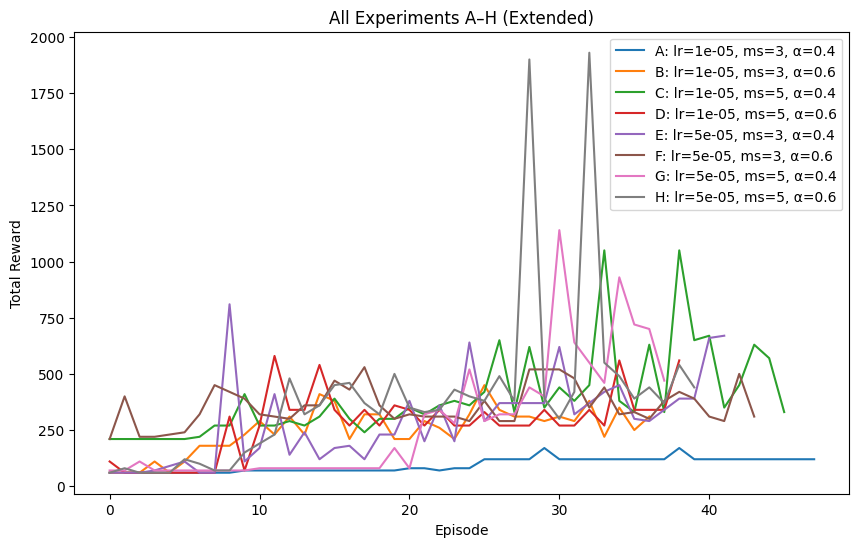

In [ ]:
# Overlay Experiments E–H on one plot
plt.figure(figsize=(10, 6))

for key in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
    # 从你存储结果的字典里取出超参和对应的 rewards 列表
    h, rewards = all_results_large[key]  # 如果你用的是 all_results_large，就改成 all_results_large[key]
    
    # 画出 mean curve
    plt.plot(
        rewards,
        label=f"{key}: lr={h['learning_rate']}, ms={h['multi_step']}, α={h['alpha']}"
    )

plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("All Experiments A–H (Extended)")
plt.legend()
plt.show()

In [ ]:
# Example: run Experiment F across 3 seeds
hparams_F_seed = {
    'learning_rate': 5e-5,
    'gamma': 0.99,
    'buffer_size': 1000000,
    'batch_size': 32,
    'multi_step': 3,
    'update_target_every': 5000,
    'alpha': 0.6,
    'beta_start': 0.4,
    'beta_frames': 500000,
    'total_frames': 30000
}
seeds = [0, 1, 2]
runs_F_seed = run_experiment_seeds(hparams_F_seed, seeds)
all_results_seeds['F_seed'] = (hparams_F_seed, runs_F_seed)

Training:   2%|▏         | 628/30000 [01:15<1:00:18,  8.12it/s, Episode Reward=60]

Frame: 627, Episode Reward: 60.0


Training:   4%|▍         | 1275/30000 [02:51<1:11:51,  6.66it/s, Episode Reward=60]

Frame: 1274, Episode Reward: 60.0


Training:   7%|▋         | 2224/30000 [05:17<1:15:54,  6.10it/s, Episode Reward=430]

Frame: 2223, Episode Reward: 430.0


Training:  11%|█         | 3210/30000 [07:53<1:08:09,  6.55it/s, Episode Reward=180]

Frame: 3209, Episode Reward: 180.0


Training:  15%|█▌        | 4559/30000 [11:21<1:05:46,  6.45it/s, Episode Reward=230]

Frame: 4559, Episode Reward: 230.0


Training:  20%|█▉        | 5961/30000 [15:03<1:02:49,  6.38it/s, Episode Reward=250]

Frame: 5960, Episode Reward: 250.0


Training:  23%|██▎       | 6915/30000 [17:35<1:04:39,  5.95it/s, Episode Reward=250]

Frame: 6914, Episode Reward: 250.0


Training:  26%|██▌       | 7746/30000 [19:46<1:00:30,  6.13it/s, Episode Reward=270]

Frame: 7745, Episode Reward: 270.0


Training:  31%|███       | 9318/30000 [23:56<55:26,  6.22it/s, Episode Reward=880]  

Frame: 9317, Episode Reward: 880.0


Training:  34%|███▍      | 10240/30000 [26:28<52:36,  6.26it/s, Episode Reward=670]  

Frame: 10239, Episode Reward: 670.0


Training:  38%|███▊      | 11262/30000 [29:13<54:57,  5.68it/s, Episode Reward=1930.0]

Frame: 11261, Episode Reward: 1930.0


Training:  40%|███▉      | 11851/30000 [30:51<48:45,  6.20it/s, Episode Reward=410]     

Frame: 11850, Episode Reward: 410.0


Training:  42%|████▏     | 12654/30000 [34:03<1:26:45,  3.33it/s, Episode Reward=280]

Frame: 12654, Episode Reward: 280.0


Training:  45%|████▌     | 13567/30000 [37:49<1:09:58,  3.91it/s, Episode Reward=700]

Frame: 13567, Episode Reward: 700.0


Training:  49%|████▊     | 14611/30000 [41:31<43:02,  5.96it/s, Episode Reward=1350.0]

Frame: 14610, Episode Reward: 1350.0


Training:  51%|█████     | 15295/30000 [43:25<41:43,  5.87it/s, Episode Reward=290]   

Frame: 15294, Episode Reward: 290.0


Training:  54%|█████▍    | 16153/30000 [45:47<40:30,  5.70it/s, Episode Reward=320]

Frame: 16152, Episode Reward: 320.0


Training:  56%|█████▌    | 16857/30000 [47:45<45:12,  4.85it/s, Episode Reward=590]

Frame: 16857, Episode Reward: 590.0


Training:  59%|█████▉    | 17677/30000 [50:03<35:34,  5.77it/s, Episode Reward=310]

Frame: 17676, Episode Reward: 310.0


Training:  60%|██████    | 18088/30000 [51:12<31:17,  6.34it/s, Episode Reward=130]

Frame: 18087, Episode Reward: 130.0


Training:  63%|██████▎   | 18800/30000 [53:12<30:16,  6.17it/s, Episode Reward=320]

Frame: 18799, Episode Reward: 320.0


Training:  65%|██████▍   | 19462/30000 [55:03<31:17,  5.61it/s, Episode Reward=320]

Frame: 19461, Episode Reward: 320.0


Training:  66%|██████▋   | 19936/30000 [56:22<28:07,  5.97it/s, Episode Reward=210]

Frame: 19935, Episode Reward: 210.0


Training:  69%|██████▉   | 20730/30000 [58:35<26:18,  5.87it/s, Episode Reward=500]

Frame: 20729, Episode Reward: 500.0


Training:  71%|███████   | 21312/30000 [1:00:16<24:31,  5.90it/s, Episode Reward=360]

Frame: 21311, Episode Reward: 360.0


Training:  73%|███████▎  | 22008/30000 [1:02:13<21:09,  6.29it/s, Episode Reward=320]

Frame: 22007, Episode Reward: 320.0


Training:  75%|███████▌  | 22641/30000 [1:04:01<21:36,  5.68it/s, Episode Reward=680]

Frame: 22640, Episode Reward: 680.0


Training:  77%|███████▋  | 23056/30000 [1:05:11<20:33,  5.63it/s, Episode Reward=150]

Frame: 23055, Episode Reward: 150.0


Training:  80%|███████▉  | 23953/30000 [1:07:41<18:16,  5.52it/s, Episode Reward=440]

Frame: 23952, Episode Reward: 440.0


Training:  83%|████████▎ | 24802/30000 [1:10:05<15:18,  5.66it/s, Episode Reward=540]

Frame: 24801, Episode Reward: 540.0


Training:  84%|████████▍ | 25254/30000 [1:11:26<14:10,  5.58it/s, Episode Reward=310]

Frame: 25253, Episode Reward: 310.0


Training:  86%|████████▌ | 25718/30000 [1:12:59<14:20,  4.98it/s, Episode Reward=250]

Frame: 25718, Episode Reward: 250.0


Training:  88%|████████▊ | 26520/30000 [1:15:32<10:04,  5.75it/s, Episode Reward=1450.0]

Frame: 26519, Episode Reward: 1450.0


Training:  91%|█████████ | 27260/30000 [1:17:52<07:54,  5.78it/s, Episode Reward=320]   

Frame: 27259, Episode Reward: 320.0


Training:  94%|█████████▍| 28265/30000 [1:20:59<05:40,  5.10it/s, Episode Reward=720]

Frame: 28264, Episode Reward: 720.0


Training:  98%|█████████▊| 29501/30000 [1:24:47<01:23,  5.98it/s, Episode Reward=1320.0]

Frame: 29501, Episode Reward: 1320.0


Training: 100%|█████████▉| 29890/30000 [1:25:59<00:20,  5.36it/s, Episode Reward=180]   

Frame: 29889, Episode Reward: 180.0


Training: 100%|██████████| 30000/30000 [1:26:19<00:00,  5.79it/s, Episode Reward=180]


▶Training finished!


Training:   2%|▏         | 641/30000 [02:00<1:45:28,  4.64it/s, Episode Reward=60]

Frame: 640, Episode Reward: 60.0


Training:   4%|▍         | 1292/30000 [04:12<1:24:50,  5.64it/s, Episode Reward=60]

Frame: 1291, Episode Reward: 60.0


Training:   7%|▋         | 2032/30000 [06:32<1:58:17,  3.94it/s, Episode Reward=210]

Frame: 2032, Episode Reward: 210.0


Training:   8%|▊         | 2526/30000 [08:07<1:24:50,  5.40it/s, Episode Reward=220]

Frame: 2525, Episode Reward: 220.0


Training:  10%|█         | 3029/30000 [09:39<1:23:08,  5.41it/s, Episode Reward=270]

Frame: 3028, Episode Reward: 270.0


Training:  12%|█▏        | 3655/30000 [11:47<1:30:22,  4.86it/s, Episode Reward=400]

Frame: 3654, Episode Reward: 400.0


Training:  14%|█▍        | 4254/30000 [13:46<1:21:27,  5.27it/s, Episode Reward=430]

Frame: 4253, Episode Reward: 430.0


Training:  16%|█▌        | 4854/30000 [15:40<1:20:06,  5.23it/s, Episode Reward=290]

Frame: 4853, Episode Reward: 290.0


Training:  18%|█▊        | 5480/30000 [17:40<1:17:06,  5.30it/s, Episode Reward=400]

Frame: 5479, Episode Reward: 400.0


Training:  20%|██        | 6067/30000 [19:35<1:15:40,  5.27it/s, Episode Reward=260]

Frame: 6066, Episode Reward: 260.0


Training:  22%|██▏       | 6685/30000 [21:34<1:17:45,  5.00it/s, Episode Reward=250]

Frame: 6685, Episode Reward: 250.0


Training:  24%|██▎       | 7122/30000 [23:02<1:14:07,  5.14it/s, Episode Reward=290]

Frame: 7121, Episode Reward: 290.0


Training:  27%|██▋       | 7956/30000 [25:29<1:25:47,  4.28it/s, Episode Reward=380]

Frame: 7956, Episode Reward: 380.0


Training:  28%|██▊       | 8488/30000 [27:04<1:02:30,  5.74it/s, Episode Reward=310]

Frame: 8487, Episode Reward: 310.0


Training:  31%|███       | 9158/30000 [29:02<1:02:41,  5.54it/s, Episode Reward=440]

Frame: 9157, Episode Reward: 440.0


Training:  33%|███▎      | 9768/30000 [30:49<1:00:03,  5.61it/s, Episode Reward=330]

Frame: 9767, Episode Reward: 330.0


Training:  35%|███▍      | 10398/30000 [32:40<55:45,  5.86it/s, Episode Reward=430]  

Frame: 10397, Episode Reward: 430.0


Training:  36%|███▌      | 10818/30000 [33:54<53:37,  5.96it/s, Episode Reward=270]  

Frame: 10817, Episode Reward: 270.0


Training:  38%|███▊      | 11402/30000 [35:38<52:48,  5.87it/s, Episode Reward=300]  

Frame: 11401, Episode Reward: 300.0


Training:  40%|███▉      | 11986/30000 [37:21<49:54,  6.02it/s, Episode Reward=360]  

Frame: 11985, Episode Reward: 360.0


Training:  42%|████▏     | 12665/30000 [39:19<48:13,  5.99it/s, Episode Reward=370]  

Frame: 12664, Episode Reward: 370.0


Training:  45%|████▍     | 13413/30000 [41:24<48:36,  5.69it/s, Episode Reward=430]

Frame: 13412, Episode Reward: 430.0


Training:  47%|████▋     | 14050/30000 [43:12<45:41,  5.82it/s, Episode Reward=280]

Frame: 14049, Episode Reward: 280.0


Training:  49%|████▉     | 14658/30000 [44:54<44:30,  5.75it/s, Episode Reward=250]  

Frame: 14657, Episode Reward: 250.0


Training:  51%|█████     | 15181/30000 [46:23<42:22,  5.83it/s, Episode Reward=330]

Frame: 15180, Episode Reward: 330.0


Training:  53%|█████▎    | 15914/30000 [48:27<39:00,  6.02it/s, Episode Reward=630]

Frame: 15913, Episode Reward: 630.0


Training:  55%|█████▍    | 16463/30000 [50:00<38:44,  5.82it/s, Episode Reward=390]

Frame: 16462, Episode Reward: 390.0


Training:  57%|█████▋    | 17089/30000 [51:50<36:10,  5.95it/s, Episode Reward=270]

Frame: 17089, Episode Reward: 270.0


Training:  58%|█████▊    | 17544/30000 [53:07<36:31,  5.68it/s, Episode Reward=300]

Frame: 17543, Episode Reward: 300.0


Training:  60%|██████    | 18057/30000 [54:34<32:20,  6.15it/s, Episode Reward=250]

Frame: 18056, Episode Reward: 250.0


Training:  62%|██████▏   | 18715/30000 [56:26<30:43,  6.12it/s, Episode Reward=390]

Frame: 18714, Episode Reward: 390.0


Training:  64%|██████▍   | 19259/30000 [58:02<29:16,  6.11it/s, Episode Reward=270]

Frame: 19258, Episode Reward: 270.0


Training:  66%|██████▋   | 19948/30000 [1:00:00<29:49,  5.62it/s, Episode Reward=270]

Frame: 19947, Episode Reward: 270.0


Training:  69%|██████▊   | 20579/30000 [1:01:46<27:47,  5.65it/s, Episode Reward=480]

Frame: 20578, Episode Reward: 480.0


Training:  71%|███████   | 21166/30000 [1:03:27<25:51,  5.69it/s, Episode Reward=270]

Frame: 21165, Episode Reward: 270.0


Training:  72%|███████▏  | 21714/30000 [1:05:01<24:32,  5.63it/s, Episode Reward=330]

Frame: 21713, Episode Reward: 330.0


Training:  74%|███████▍  | 22190/30000 [1:06:28<22:28,  5.79it/s, Episode Reward=340]

Frame: 22189, Episode Reward: 340.0


Training:  76%|███████▌  | 22768/30000 [1:08:07<20:09,  5.98it/s, Episode Reward=320]

Frame: 22767, Episode Reward: 320.0


Training:  78%|███████▊  | 23495/30000 [1:10:14<18:52,  5.75it/s, Episode Reward=460]

Frame: 23494, Episode Reward: 460.0


Training:  80%|████████  | 24084/30000 [1:11:59<19:53,  4.96it/s, Episode Reward=260]

Frame: 24084, Episode Reward: 260.0


Training:  82%|████████▏ | 24536/30000 [1:13:24<14:50,  6.14it/s, Episode Reward=300]

Frame: 24535, Episode Reward: 300.0


Training:  84%|████████▍ | 25192/30000 [1:15:14<12:41,  6.31it/s, Episode Reward=420]

Frame: 25191, Episode Reward: 420.0


Training:  86%|████████▋ | 25926/30000 [1:17:28<11:57,  5.68it/s, Episode Reward=420]

Frame: 25925, Episode Reward: 420.0


Training:  88%|████████▊ | 26428/30000 [1:18:57<10:50,  5.49it/s, Episode Reward=260]

Frame: 26427, Episode Reward: 260.0


Training:  90%|████████▉ | 26923/30000 [1:20:22<09:04,  5.65it/s, Episode Reward=300]

Frame: 26922, Episode Reward: 300.0


Training:  93%|█████████▎| 27901/30000 [1:23:12<06:15,  5.59it/s, Episode Reward=410]

Frame: 27900, Episode Reward: 410.0


Training:  95%|█████████▍| 28442/30000 [1:24:45<04:32,  5.72it/s, Episode Reward=310]

Frame: 28441, Episode Reward: 310.0


Training:  97%|█████████▋| 29010/30000 [1:26:24<02:47,  5.91it/s, Episode Reward=260]

Frame: 29009, Episode Reward: 260.0


Training:  99%|█████████▊| 29559/30000 [1:27:59<01:19,  5.57it/s, Episode Reward=210]

Frame: 29558, Episode Reward: 210.0


Training: 100%|██████████| 30000/30000 [1:29:18<00:00,  5.60it/s, Episode Reward=210]


▶Training finished!


Training:   2%|▏         | 646/30000 [01:49<1:26:33,  5.65it/s, Episode Reward=60]

Frame: 645, Episode Reward: 60.0


Training:   5%|▍         | 1444/30000 [04:13<1:30:32,  5.26it/s, Episode Reward=230]

Frame: 1443, Episode Reward: 230.0


Training:   8%|▊         | 2264/30000 [06:41<1:20:56,  5.71it/s, Episode Reward=230]

Frame: 2263, Episode Reward: 230.0


Training:  10%|▉         | 2950/30000 [08:52<1:24:48,  5.32it/s, Episode Reward=290]

Frame: 2949, Episode Reward: 290.0


Training:  12%|█▏        | 3594/30000 [10:53<1:20:00,  5.50it/s, Episode Reward=190]

Frame: 3593, Episode Reward: 190.0


Training:  15%|█▍        | 4487/30000 [13:42<1:15:13,  5.65it/s, Episode Reward=210]

Frame: 4486, Episode Reward: 210.0


Training:  18%|█▊        | 5272/30000 [16:13<1:16:28,  5.39it/s, Episode Reward=330]

Frame: 5271, Episode Reward: 330.0


Training:  21%|██        | 6200/30000 [19:10<1:19:13,  5.01it/s, Episode Reward=500]

Frame: 6199, Episode Reward: 500.0


Training:  24%|██▍       | 7192/30000 [22:16<1:12:08,  5.27it/s, Episode Reward=1070.0]

Frame: 7191, Episode Reward: 1070.0


Training:  27%|██▋       | 8205/30000 [26:07<1:09:11,  5.25it/s, Episode Reward=500]   

Frame: 8204, Episode Reward: 500.0


Training:  32%|███▏      | 9450/30000 [30:52<1:09:49,  4.90it/s, Episode Reward=480]

Frame: 9450, Episode Reward: 480.0


Training:  34%|███▍      | 10239/30000 [34:05<1:16:26,  4.31it/s, Episode Reward=350]

Frame: 10239, Episode Reward: 350.0


Training:  36%|███▌      | 10837/30000 [36:27<1:15:11,  4.25it/s, Episode Reward=350]

Frame: 10837, Episode Reward: 350.0


Training:  39%|███▉      | 11679/30000 [40:02<1:11:24,  4.28it/s, Episode Reward=360]

Frame: 11679, Episode Reward: 360.0


Training:  41%|████▏     | 12396/30000 [43:03<1:15:27,  3.89it/s, Episode Reward=380]

Frame: 12396, Episode Reward: 380.0


Training:  44%|████▍     | 13171/30000 [46:28<1:27:24,  3.21it/s, Episode Reward=380]

Frame: 13171, Episode Reward: 380.0


Training:  46%|████▌     | 13840/30000 [48:47<51:38,  5.22it/s, Episode Reward=330]  

Frame: 13839, Episode Reward: 330.0


Training:  48%|████▊     | 14467/30000 [51:02<55:11,  4.69it/s, Episode Reward=300]  

Frame: 14467, Episode Reward: 300.0


Training:  52%|█████▏    | 15586/30000 [54:51<58:49,  4.08it/s, Episode Reward=300]  

Frame: 15586, Episode Reward: 300.0


Training:  54%|█████▍    | 16200/30000 [56:54<54:12,  4.24it/s, Episode Reward=390]  

Frame: 16199, Episode Reward: 390.0


Training:  56%|█████▌    | 16857/30000 [59:04<43:58,  4.98it/s, Episode Reward=380]

Frame: 16857, Episode Reward: 380.0


Training:  59%|█████▊    | 17589/30000 [1:01:34<40:32,  5.10it/s, Episode Reward=360]

Frame: 17589, Episode Reward: 360.0


Training:  61%|██████    | 18233/30000 [1:03:54<39:23,  4.98it/s, Episode Reward=340]

Frame: 18232, Episode Reward: 340.0


Training:  64%|██████▍   | 19185/30000 [1:07:23<38:25,  4.69it/s, Episode Reward=320]

Frame: 19185, Episode Reward: 320.0


Training:  66%|██████▌   | 19827/30000 [1:09:42<29:50,  5.68it/s, Episode Reward=330]  

Frame: 19826, Episode Reward: 330.0


Training:  69%|██████▉   | 20722/30000 [1:13:36<42:29,  3.64it/s, Episode Reward=470]  

Frame: 20722, Episode Reward: 470.0


Training:  72%|███████▏  | 21550/30000 [1:17:14<34:21,  4.10it/s, Episode Reward=320]  

Frame: 21550, Episode Reward: 320.0


Training:  74%|███████▍  | 22308/30000 [1:20:16<27:41,  4.63it/s, Episode Reward=300]  

Frame: 22308, Episode Reward: 300.0


Training:  77%|███████▋  | 23012/30000 [1:23:05<34:39,  3.36it/s, Episode Reward=360]

Frame: 23012, Episode Reward: 360.0


Training:  79%|███████▉  | 23773/30000 [1:26:13<25:05,  4.14it/s, Episode Reward=320]

Frame: 23773, Episode Reward: 320.0


Training:  82%|████████▏ | 24482/30000 [1:29:07<22:13,  4.14it/s, Episode Reward=240]

Frame: 24482, Episode Reward: 240.0


Training:  84%|████████▍ | 25180/30000 [1:32:00<20:04,  4.00it/s, Episode Reward=340]

Frame: 25180, Episode Reward: 340.0


Training:  88%|████████▊ | 26307/30000 [1:36:46<14:50,  4.15it/s, Episode Reward=430]

Frame: 26307, Episode Reward: 430.0


Training:  90%|█████████ | 27090/30000 [1:41:04<19:53,  2.44it/s, Episode Reward=310]

Frame: 27090, Episode Reward: 310.0


Training:  93%|█████████▎| 27863/30000 [1:44:23<07:52,  4.52it/s, Episode Reward=270]

Frame: 27863, Episode Reward: 270.0


Training:  95%|█████████▌| 28579/30000 [1:46:52<05:03,  4.69it/s, Episode Reward=320]

Frame: 28578, Episode Reward: 320.0


Training:  98%|█████████▊| 29443/30000 [1:49:50<01:47,  5.18it/s, Episode Reward=350]

Frame: 29443, Episode Reward: 350.0


Training: 100%|██████████| 30000/30000 [1:51:45<00:00,  4.47it/s, Episode Reward=350]


▶Training finished!
